# Deepmind TurnerLab (Pillar IV) Dataset 06-07-2023

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*


In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import gzip                             # for compressing files 
import torch                            # for neural networks
import torch.nn as nn                   # for neural networks
import torch.nn.functional as F         # for neural networks
from torch.utils.data import TensorDataset, DataLoader # for neural networks
import copy                             # for copying objects

# import statistics modules
from scipy.stats import wilcoxon       # for wilcoxon signed-rank test
from sklearn.cluster import AgglomerativeClustering # for clustering
from scipy.optimize import minimize

# import cognitive models
from pygorl.cogpolicy import *     # Cognitive Policy Learning models
from pygorl.cogq import *          # Cognitive Q-learning models

# import sklearn modules
from sklearn.linear_model import LogisticRegression # for logistic regression

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.colors as colors      # for truncating colormaps

# define function for truncating colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# define truncated colormap of RdYlGn for Orange-Green
OrGn = truncate_colormap(plt.get_cmap('RdYlGn'), 0.3, 0.9)

# statistical tests
from scipy import stats

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def cohensd(x,y):
    """
    Calculate Cohen's d
    """
    # calculate the size of samples
    n1, n2 = len(x), len(y)
    # calculate the variance of the samples
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    # calculate the means of the samples
    u1, u2 = np.mean(x), np.mean(y)
    # calculate the effect size
    return (u1 - u2) / s

# set all text color to white
plt.rcParams.update({'text.color' : "white",
                        'axes.labelcolor' : "white",
                        'xtick.color' : "white",
                        'ytick.color' : "white"})
# set background color to transparent
plt.rcParams.update({'axes.facecolor': "None",
                        'figure.facecolor': "None",
                        'savefig.facecolor': "None"})

# import mixed effect logistic regression model from statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
data_path = '../data/dmData_14-09-2023/' # path to data files
fit_path = '../processed_data/dmData_14-09-2023/' # path to fitted models
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = '2024-06-10 00:00:00' # last date of data collection
recalculate = False # whether to recalculate all data (True) or load from file (False)

In [3]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')
trial_duration_data = np.loadtxt(data_path + 'trial_lengths.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)
trial_duration_data = trial_duration_data.astype(float)

if choice_data.shape != reward_data.shape or choice_data.shape != trial_duration_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# load metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

# load quality control data
qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)

Data loaded successfully with N = 446 flies and 1318 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/550774320.py:9: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/550774320.py:10: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


In [4]:
# remove all control flies
choice_data = choice_data[metadata['Fly Experiment'] != 'control.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control.csv']
trial_duration_data = trial_duration_data[metadata['Fly Experiment'] != 'control.csv']
qc = qc[metadata['Fly Experiment'] != 'control.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control.csv']
choice_data = choice_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
trial_duration_data = trial_duration_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
qc = qc[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata.reset_index(drop=True, inplace=True)

In [5]:
# QUALITY CONTROL

if quality_control == 'minimal':
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    trial_duration_data = trial_duration_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    trial_duration_data = trial_duration_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

360/446 (80.72) flies passed quality control


In [6]:
def get_probabilities(fly_no,return_trial_count=False):
    exp_name = metadata['Fly Experiment'][fly_no]
    exp_data = pd.read_csv(data_path+'experiments/'+exp_name)
    trial_count = sum(choice_data[fly_no,:] >= 0)
    # get probability of choosing reward for each odor
    p_1 = exp_data['P(R|O1)'].values[:trial_count]
    p_2 = exp_data['P(R|O2)'].values[:trial_count]
    if return_trial_count:
        return p_1, p_2, trial_count
    else:
        return p_1, p_2

def get_blocks(fly_no,return_n_blocks=False):
    """
    Get blocks for a given fly
    """
    p_1, p_2, trial_count = get_probabilities(fly_no,return_trial_count=True)
    # get block transitions
    block_transitions = np.logical_or(np.diff(p_1) != 0, np.diff(p_2) != 0)
    n_blocks = np.sum(block_transitions)
    block_transitions = np.concatenate(([0], block_transitions)) # account for first trial
    block_no = np.cumsum(block_transitions) # block number for each trial
    # loop over blocks
    block_data = []
    for b in np.unique(block_no):
        p_1_b = np.unique(p_1[block_no == b])[0]
        p_2_b = np.unique(p_2[block_no == b])[0]
        n_trials = np.sum(block_no == b)
        choices = choice_data[:,:trial_count][fly_no,block_no == b]
        rewards = reward_data[:,:trial_count][fly_no,block_no == b]
        block_length = np.sum(block_no == b)
        block_data.append({'p_1':p_1_b, 'p_2':p_2_b, 'choices':choices, 'rewards':rewards, 'block_length':block_length})
    return (block_data, n_blocks) if return_n_blocks else block_data

### What explains the variance in the data?

The initial goal to to figure out a baseline estimate of well we understand the data. There are two baselines to consider for tasks like this:

1. **Probabilistic Win-Stay-Lose-Go (WSLG) models:** These models are based on the idea that animals are more likely to repeat a choice if they won on the previous trial, and more likely to leave if they lost on the previous trial. These models are a good baseline because they are simple, and they are based on a well-established psychological theory.

2. **Logistic Regression (LR) models:** These models are based on the idea that the recent history of choices and rewards can be used to predict the current choice. These models are a good baseline because they are flexible and easy to interpret.

#### Note:
*We will use a odd-even cross validation analysis for all of the models. This means that we will train the model on odd trials and test it on even trials, and then train the model on even trials and test it on odd trials. This is a good way to make sure that the model is not overfitting to the data.*

In [7]:
# Helper Functions for Dataset

def get_valid_data(x):
    # check if x in a numpy array
    if not isinstance(x, np.ndarray):
        x_ = np.array(x)
    else:
        x_ = x.copy()
    x_ = x_[~np.isnan(x_)]
    x_ = x_[~np.isinf(x_)]
    x_ = x_[x_>=0]
    return x_

def get_split_data(choices=choice_data, rewards=reward_data, K=2):
    """
    Get the split choice and reward data for a given number of folds.
    
    Parameters
    ----------
    choices : numpy.ndarray
        The choice data.
    rewards : numpy.ndarray
        The reward data.
    K : int
        The number of folds.
    """
    vals = []
    for i in range(K):
        cs_temp = choices[i::K]
        cs = []
        for c in cs_temp:
            cs += [get_valid_data(c)]
        rs_temp = rewards[i::K]
        rs = []
        for r in rs_temp:
            rs += [get_valid_data(r)]
        vals.append((cs, rs))
    return vals

def log_likelihood(predictions,observations):
    """
    Calculate the bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        lls += [np.sum(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i]))]
    return lls

def normalized_log_likelihood(predictions,observations):
    """
    Calculate the normalized bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    norm_lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        norm_lls += [np.exp(np.mean(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i])))]
    return norm_lls

# Storing all data directories
all_models = {}

# create fit directory if it doesn't exist
if not os.path.exists(fit_path):
    os.makedirs(fit_path)
    os.makedirs(fit_path + 'fit_results/')


In [8]:
# choices = [get_valid_data(x) for x in choice_data]
# rewards = [get_valid_data(x) for x in reward_data]

# fly_id = 0
# history_size = 30
# n_bins = 10

# q_updates = np.zeros((2,2,n_bins,n_bins,2))
# q_updates_count = np.zeros((2,2,n_bins,n_bins,2))

# for fly_id in tqdm(range(len(choices))):
#     for trial in range(1,len(choices[fly_id])-1):
#         c_history = choices[fly_id][max(0,trial-history_size):trial+1]
#         r_history = rewards[fly_id][max(0,trial-history_size):trial+1]

#         current_c = c_history[-2]
#         current_r = r_history[-2]
#         c_next = choices[fly_id][trial]


#         # calculate the reward ratio (r1/(r0+r1))
#         r0_pre = np.mean(np.logical_and(c_history[:-1] == 0, r_history[:-1] == 1))
#         r1_pre = np.mean(np.logical_and(c_history[:-1] == 1, r_history[:-1] == 1))

#         r0_post = np.mean(np.logical_and(c_history[1:] == 0, r_history[1:] == 1))
#         r1_post = np.mean(np.logical_and(c_history[1:] == 1, r_history[1:] == 1))

#         # calculate the change in reward ratio
#         r0_change = r0_post - r0_pre
#         r1_change = r1_post - r1_pre

#         # bin between 0 and 1 with n_bins
#         r0 = np.digitize(r0_pre, np.linspace(0,1,n_bins), right=False)-1
#         r1 = np.digitize(r1_pre, np.linspace(0,1,n_bins), right=False)-1

#         # add to q_updates
#         q_updates[current_c,current_r,r0,r1,0] += r0_change
#         q_updates_count[current_c,current_r,r0,r1,0] += 1
#         q_updates[current_c,current_r,r0,r1,1] += r1_change
#         q_updates_count[current_c,current_r,r0,r1,1] += 1

# # calculate the average q_updates after filtering out anyting that has a count of 10 or less
# q_updates_count[q_updates_count < 10] = 0
# q_updates = q_updates/q_updates_count


In [9]:
# odor_1_unrewarded = q_updates[0,0,:,:,:]
# odor_1_rewarded = q_updates[0,1,:,:,:]
# odor_2_unrewarded = q_updates[1,0,:,:,:]
# odor_2_rewarded = q_updates[1,1,:,:,:]

# # smooth the q_updates
# from scipy import signal
# # kernel = np.ones((3,3))
# # kernel = kernel/np.sum(kernel)
# # odor_1_unrewarded = np.array([signal.convolve2d(odor_1_unrewarded[:,:,i], kernel, mode='same') for i in range(2)]).transpose(1,2,0)
# # odor_1_rewarded = np.array([signal.convolve2d(odor_1_rewarded[:,:,i], kernel, mode='same') for i in range(2)]).transpose(1,2,0)
# # odor_2_unrewarded = np.array([signal.convolve2d(odor_2_unrewarded[:,:,i], kernel, mode='same') for i in range(2)]).transpose(1,2,0)
# # odor_2_rewarded = np.array([signal.convolve2d(odor_2_rewarded[:,:,i], kernel, mode='same') for i in range(2)]).transpose(1,2,0)



In [10]:
# # quiver plot for odor 1
# fig, ax = plt.subplots(1,2,figsize=(6,3))
# X, Y = np.meshgrid(np.linspace(0,1,n_bins), np.linspace(0,1,n_bins))
# U = odor_1_unrewarded[:,:,0].T
# V = odor_1_unrewarded[:,:,1].T
# C = np.sqrt(U**2 + V**2)
# ax[0].quiver(X, Y, U, V, C, cmap=OrGn)
# ax[0].set_title('Odor 1 Unrewarded')
# ax[0].set_xlabel('P(R|O1)')
# ax[0].set_ylabel('P(R|O2)')


# U = odor_1_rewarded[:,:,0].T
# V = odor_1_rewarded[:,:,1].T
# C = np.sqrt(U**2 + V**2)
# ax[1].quiver(X, Y, U, V, C, cmap=OrGn)
# ax[1].set_title('Odor 1 Rewarded')
# ax[1].set_xlabel('P(R|O1)')
# ax[1].set_ylabel('P(R|O2)')



# plt.show()

# # quiver plot for odor 2
# fig, ax = plt.subplots(1,2,figsize=(6,3))
# X, Y = np.meshgrid(np.linspace(0,1,n_bins), np.linspace(0,1,n_bins))
# U = odor_2_unrewarded[:,:,0].T
# V = odor_2_unrewarded[:,:,1].T
# C = np.sqrt(U**2 + V**2)
# ax[0].quiver(X, Y, U, V, C, cmap=OrGn)
# ax[0].set_title('Odor 2 Unrewarded')
# ax[0].set_xlabel('P(R|O1)')
# ax[0].set_ylabel('P(R|O2)')


# U = odor_2_rewarded[:,:,0].T
# V = odor_2_rewarded[:,:,1].T
# C = np.sqrt(U**2 + V**2)
# ax[1].quiver(X, Y, U, V, C, cmap=OrGn)
# ax[1].set_title('Odor 2 Rewarded')
# ax[1].set_xlabel('P(R|O1)')
# ax[1].set_ylabel('P(R|O2)')
# plt.show()




In [11]:
all_models = {}

### Fitting a WSLG model to the data

We can easily do this by looking at the next choices after every win and loss to estimate transition probabilities. We can then use these probabilities as the parameters of a WSLG model.

The model is as follows:

Let $p_{stay}$ be the probability of staying with the same choice after a win, and $p_{go}$ be the probability of switching after a loss. Then the transition probabilities are:

$$
\begin{align}
p(\text{stay}|\text{win}) &= p_{stay} \\
p(\text{switch}|\text{win}) &= 1 - p_{stay} \\
p(\text{stay}|\text{loss}) &= 1 - p_{go} \\
p(\text{switch}|\text{loss}) &= p_{go}
\end{align}
$$

In [12]:
# FUNCTIONS TO FIT WSLG BASELINE MODEL

def fit_wslg(choices,rewards):
    """
    Fit the win-stay-lose-go model to the data.
    """
    # get length of data
    N = len(choices)
    stays = []
    gos = []
    for i in range(N):
        r,c = rewards[i],choices[i]
        assert len(r) == len(c), "Data length mismatch"
        # get every win and loss
        win = np.where(r[:-1] == 1)[0]
        loss = np.where(r[:-1] == 0)[0]
        # get stays and switches
        stays.append(c[win] == c[win+1])
        gos.append(c[loss] != c[loss+1])
    p_stay = np.mean(np.concatenate(stays))
    p_go = np.mean(np.concatenate(gos))
    return p_stay, p_go

def predict_prob_wslg(choices,rewards,p_stay,p_go):
    """
    Predict the probability of choosing odor 2 for each trial.
    """
    # get length of data
    N = len(choices)
    probs = []
    for i in range(N):
        r,c = rewards[i],choices[i]
        assert len(r) == len(c), "Data length mismatch"
        p = 0.5*np.ones(len(r))
        for j in range(len(r)-1):
            if r[j] == 1:
                if c[j] == 0:
                    p[j+1] = 1-p_stay
                else:
                    p[j+1] = p_stay
            else:
                if c[j] == 0:
                    p[j+1] = 1-p_go
                else:
                    p[j+1] = p_go
        probs.append(p)
    return probs

In [13]:
# SPLIT AND FIT THE DATA

# Check if fit has already been run
if os.path.isfile(fit_path+'fit_results/wslg_fit_results.pkl.gz') and recalculate == False:
    # Load the results
    with gzip.open(fit_path+'fit_results/wslg_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded fit results from disk.")
    # Unpack the results
    params = all_data['params']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']

# Otherwise, run the fit
else:
    split_data = get_split_data()
    
    # Variables to store the results
    params = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        p_stay, p_go = fit_wslg(choices, rewards)
        # Store the parameters
        params.append((p_stay, p_go))
        # Compute the log likelihoods
        probs = predict_prob_wslg(choices, rewards, p_stay, p_go)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_wslg(choices, rewards, *params[n])
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/wslg_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


# Parameters
print("ESTIMATED WIN-STAY LOSE-GO MODEL PARAMETERS")
print("===========================================")
print()
p_stay, p_go = np.mean(params, axis=0)
print('p_stay: {:.3f} [{:.3f}, {:.3f}]'.format(
    p_stay, *np.percentile(params, [2.5, 97.5], axis=0)[:, 0]))
print('p_go: {:.3f} [{:.3f}, {:.3f}]'.format(
    p_go, *np.percentile(params, [2.5, 97.5], axis=0)[:, 1]))

# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))

# Add to models list
all_models['pWLSG'] = fit_path+'fit_results/wslg_fit_results.pkl.gz'

Loaded fit results from disk.
ESTIMATED WIN-STAY LOSE-GO MODEL PARAMETERS

p_stay: 0.689 [0.681, 0.698]
p_go: 0.435 [0.433, 0.437]

MODEL FIT

Train log likelihood: -315.197 [-619.099, -130.562]
Test log likelihood: -315.312 [-614.782, -130.620]
Train normalized log likelihood: 0.511 [0.477, 0.567]
Test normalized log likelihood: 0.511 [0.475, 0.564]


We can see that the WSLG Model can barely explain the data beyond chance levels. Lets go for a more powerful baseline model: the Logistic Regression Model

### Fitting sliding Epsilon-Greedy model to the data

Epsilon-Greedy is a simple model that is based on the idea that the recent history of choices and rewards can be used to predict the current choice. The model is as follows:

$$Q_t(a) = \text{No. of times action a was rewarded up to time t} / \text{No. of times action a was chosen up to time t}$$

with probability $1-\epsilon$, the model chooses the action with the highest $Q_t(a)$, and with probability $\epsilon$, the model chooses a random action.


In [14]:
# FUNCTIONS TO FIT WSLG BASELINE MODEL

def predict_prob_epsilon_greedy(choices,rewards,epsilon,window):
    """
    Predict the probability of choosing odor 2 for each trial using the epsilon-greedy model.
    """
    # get length of data
    N = len(choices)
    probs = []
    for i in range(N):
        r_,c_ = rewards[i],choices[i]
        assert len(r_) == len(c_), "Data length mismatch"
        p = [0.5]
        for j in range(len(r_)-1):
            # calculate with rounded down window
            window_ = int(np.floor(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            q_1 = np.mean(r[c==0]) if np.sum(c==0) > 0 else 0
            q_2 = np.mean(r[c==1]) if np.sum(c==1) > 0 else 0
            p_val_down = (1-epsilon)*np.argmax([q_1,q_2])+epsilon*0.5
            # calculate with rounded up window
            window_ = int(np.ceil(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            q_1 = np.mean(r[c==0]) if np.sum(c==0) > 0 else 0
            q_2 = np.mean(r[c==1]) if np.sum(c==1) > 0 else 0
            p_val_up = (1-epsilon)*np.argmax([q_1,q_2])+epsilon*0.5
            p.append(np.clip(p_val_down*(1-window%1)+p_val_up*(window%1),1e-4,1-1e-4))
        probs.append(np.array(p,dtype=float))
    probs = np.array(probs,dtype=object)
    return probs

def fit_epsilon_greedy(choices,rewards):
    """
    Fit the epsilon-greedy model to the data.
    """
    # use scipy to fit the model
    def loss(params,choices,rewards):
        epsilon = params[0]
        window = params[1]
        probs = predict_prob_epsilon_greedy(choices,rewards,epsilon,window)
        return -np.sum(log_likelihood(probs,choices))
    # fit the model
    res = minimize(loss,(0.1,10),args=(choices,rewards),bounds=[(0,1),(5,450)])
    return res.x

In [15]:
# SPLIT AND FIT THE DATA

# Check if fit has already been run
if os.path.isfile(fit_path+'fit_results/epsilon_greedy_fit_results.pkl.gz') and recalculate == False:
    # Load the results
    with gzip.open(fit_path+'fit_results/epsilon_greedy_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded fit results from disk.")
    # Unpack the results
    params = all_data['params']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']
    
# Otherwise, run the fit
else:
    split_data = get_split_data()
    
    # Variables to store the results
    params = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        parameters = fit_epsilon_greedy(choices, rewards)
        # Store the parameters
        params.append(parameters)
        # Compute the log likelihoods
        probs = predict_prob_epsilon_greedy(choices, rewards, *parameters)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_epsilon_greedy(choices, rewards, *params[n])
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))
    
    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/epsilon_greedy_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)

Loaded fit results from disk.


In [16]:
# Parameters
print("ESTIMATED EPSILON-GREEDY MODEL PARAMETERS")
print("===========================================")
print()
# print epsilon and window
epsilon, window = np.mean(params, axis=0)
print('epsilon: {:.3f} [{:.3f}, {:.3f}]'.format(
    epsilon, *np.percentile(params, [2.5, 97.5], axis=0)[:, 0]))
print('window: {:.3f} [{:.3f}, {:.3f}]'.format(
    window, *np.percentile(params, [2.5, 97.5], axis=0)[:, 1]))


# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
print()

# Add to models list
all_models['pEpsGreedy'] = fit_path+'fit_results/epsilon_greedy_fit_results.pkl.gz'

ESTIMATED EPSILON-GREEDY MODEL PARAMETERS

epsilon: 0.754 [0.731, 0.777]
window: 449.607 [449.528, 449.686]

MODEL FIT

Train log likelihood: -308.709 [-616.427, -128.921]
Test log likelihood: -309.280 [-614.542, -127.548]
Train normalized log likelihood: 0.519 [0.472, 0.588]
Test normalized log likelihood: 0.518 [0.472, 0.586]



### Fitting a Perfect Matching model to the data

The Perfect Matching model is a simple model that is based on the idea that the recent history of choices and rewards can be used to predict the current choice.

In [17]:
# FUNCTIONS TO FIT PERFECT MATCH MODEL

def predict_prob_perfect_match(choices,rewards,window):
    """
    Predict the probability of choosing odor 2 for each trial using the perfect match model.
    """
    # get length of data
    N = len(choices)
    probs = []
    for i in range(N):
        r_,c_ = rewards[i],choices[i]
        assert len(r_) == len(c_), "Data length mismatch"
        p = [0.5]
        for j in range(len(r_)-1):
            # calculate with rounded down window
            window_ = int(np.floor(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            # calculate the reward ratio (r2/(r1+r2))
            r1 = np.sum(r[c==0])
            r2 = np.sum(r[c==1])
            reward_ratio = r2/(r1+r2) if r1+r2 > 0 else 0.5
            p_val_down = reward_ratio
            # calculate with rounded up window
            window_ = int(np.ceil(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            # calculate the reward ratio (r2/(r1+r2))
            r1 = np.sum(r[c==0])
            r2 = np.sum(r[c==1])
            reward_ratio = r2/(r1+r2) if r1+r2 > 0 else 0.5
            p_val_up = reward_ratio
            p.append(np.clip(p_val_down*(1-window%1)+p_val_up*(window%1),1e-4,1-1e-4))
        probs.append(np.array(p,dtype=float))
    probs = np.array(probs,dtype=object)
    return probs

def fit_perfect_match(choices,rewards):
    """
    Fit the perfect match model to the data.
    """
    # use scipy to fit the model
    def loss(params,choices,rewards):
        window = params[0]
        probs = predict_prob_perfect_match(choices,rewards,window)
        return -np.sum(log_likelihood(probs,choices))
    # fit the model
    res = minimize(loss,(10,),args=(choices,rewards),bounds=[(5,450)])
    return res.x

In [18]:
# SPLIT AND FIT THE DATA

# Check if fit has already been run
if os.path.isfile(fit_path+'fit_results/perfect_match_fit_results.pkl.gz') and recalculate == False:
    # Load the results
    with gzip.open(fit_path+'fit_results/perfect_match_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded fit results from disk.")
    # Unpack the results
    params = all_data['params']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']

# Otherwise, run the fit
else:
    split_data = get_split_data()
    
    # Variables to store the results
    params = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        parameters = fit_perfect_match(choices, rewards)
        # Store the parameters
        params.append(parameters)
        # Compute the log likelihoods
        probs = predict_prob_perfect_match(choices, rewards, *parameters)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_perfect_match(choices, rewards, *params[n])
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/perfect_match_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


Loaded fit results from disk.


In [19]:
# Parameters
print("ESTIMATED PERFECT MATCH MODEL PARAMETERS")
print("=========================================")
print()
window = np.mean(params)
print('window: {:.3f} [{:.3f}, {:.3f}]'.format(
    window, *np.percentile(params, [2.5, 97.5])))

# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5]))
)
print()

# Add to models list
all_models['pPerfect'] = fit_path+'fit_results/perfect_match_fit_results.pkl.gz'

ESTIMATED PERFECT MATCH MODEL PARAMETERS

window: 225.736 [221.371, 230.101]

MODEL FIT

Train log likelihood: -354.023 [-718.429, -126.257]
Test log likelihood: -354.086 [-715.782, -126.251]
Train normalized log likelihood: 0.476 [0.307, 0.665]
Test normalized log likelihood: 0.476 [0.307, 0.665]



### Fitting a Generalized Matching Law for the data

The Generalized Matching model is a simple model that is based on the idea that the recent history of choices and rewards can be used to predict the current choice.

In [120]:
# FUNCTIONS TO FIT GENERALIZED MATCH MODEL

def predict_prob_generalized_match(choices,rewards,window,bias, sensitivity):
    """
    Predict the probability of choosing odor 2 for each trial using the perfect match model.
    """
    # get length of data
    eps = 1e-3
    N = len(choices)
    probs = []
    for i in range(N):
        r_,c_ = rewards[i],choices[i]
        assert len(r_) == len(c_), "Data length mismatch"
        p = [0.5]
        for j in range(len(r_)-1):
            # calculate with rounded down window
            window_ = int(np.floor(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            # calculate the reward ratio (r2/(r1+r2))
            r1 = np.sum(r[c==0])
            r2 = np.sum(r[c==1])
            if r1 == 0 and r2 == 0:
                reward_ratio = 1
            elif r1 == 0 or r2 == 0:
                reward_ratio = eps if r1 == 0 else 1/eps
            else:
                reward_ratio = r2/r1
            choice_ratio = bias * reward_ratio ** sensitivity
            p_val_down = choice_ratio/(1+choice_ratio)
            # calculate with rounded up window
            window_ = int(np.ceil(window))
            r,c = r_[max(0,j-window_+1):j+1],c_[max(0,j-window_+1):j+1]
            # calculate the reward ratio (r2/(r1+r2))
            r1 = np.sum(r[c==0])
            r2 = np.sum(r[c==1])
            if r1 == 0 and r2 == 0:
                reward_ratio = 1
            elif r1 == 0 or r2 == 0:
                reward_ratio = eps if r1 == 0 else 1/eps
            else:
                reward_ratio = r2/r1
            choice_ratio = bias * reward_ratio ** sensitivity
            p_val_up = choice_ratio/(1+choice_ratio)
            p.append(np.clip(p_val_down*(1-window%1)+p_val_up*(window%1),1e-4,1-1e-4))
        probs.append(np.array(p,dtype=float))
    probs = np.array(probs,dtype=object)
    return probs

def fit_generalized_match(choices,rewards):
    """
    Fit the perfect match model to the data.
    """
    # use scipy to fit the model
    def loss(params,choices,rewards):
        window = params[0]
        bias = params[1]
        sensitivity = params[2]
        probs = predict_prob_generalized_match(choices,rewards,window,bias,sensitivity)
        return -np.sum(log_likelihood(probs,choices))
    # fit the model
    res = minimize(loss,(10,1,1,),args=(choices,rewards),bounds=[(5,450),(1e-4,1e4),(0.1,10)])
    return res.x

In [122]:
# SPLIT AND FIT THE DATA

# Check if fit has already been run
if os.path.isfile(fit_path+'fit_results/generalized_match_fit_results.pkl.gz') and recalculate == False:
    # Load the results
    with gzip.open(fit_path+'fit_results/generalized_match_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded fit results from disk.")
    # Unpack the results
    params = all_data['params']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']

# Otherwise, run the fit
else:
    split_data = get_split_data()
    
    # Variables to store the results
    params = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        parameters = fit_generalized_match(choices, rewards)
        # Store the parameters
        params.append(parameters)
        # Compute the log likelihoods
        probs = predict_prob_generalized_match(choices, rewards, *parameters)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_generalized_match(choices, rewards, *params[n])
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/generalized_match_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


In [124]:
# Parameters
print("ESTIMATED GENERALIZED MATCH MODEL PARAMETERS")
print("============================================")
print()
window = np.mean(params, axis=0)[0]
bias = np.mean(params, axis=0)[1]
sensitivity = np.mean(params, axis=0)[2]
print('window: {:.3f} [{:.3f}, {:.3f}]'.format(
    window, *np.percentile(params, [2.5, 97.5], axis=0)[:, 0]))
print('bias: {:.3f} [{:.3f}, {:.3f}]'.format(
    bias, *np.percentile(params, [2.5, 97.5], axis=0)[:, 1]))
print('sensitivity: {:.3f} [{:.3f}, {:.3f}]'.format(
    sensitivity, *np.percentile(params, [2.5, 97.5], axis=0)[:, 2]))


# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5]))
)
print()

# Add to models list
all_models['generalizedMatching'] = fit_path+'fit_results/generalized_match_fit_results.pkl.gz'

ESTIMATED GENERALIZED MATCH MODEL PARAMETERS

window: 142.249 [17.413, 267.085]
bias: 1.144 [1.113, 1.175]
sensitivity: 0.100 [0.100, 0.100]

MODEL FIT

Train log likelihood: -348.199 [-654.942, -144.545]
Test log likelihood: -350.140 [-629.089, -149.420]
Train normalized log likelihood: 0.474 [0.376, 0.536]
Test normalized log likelihood: 0.471 [0.373, 0.532]



### Fitting a Logistic Regression Model

Here, we are going to fit a simple logistic regression model on the interactions of choice and reward data using past history of 10 and 20 trials to predict the next trial.

Let $K$ be the number of past trials to use for prediction. Let $t$ be the current trial. Let $\text{C}_{t-K:t-1}$ be the sequence of choices from trial $(t-K)$ to $(t-1)$. Let $\text{R}_{(t-K):(t-1)}$ be the sequence of rewards from trial $(t-K)$ to $(t-1)$. Let $\beta_0$, $\beta_{1:K}$, $\beta_{K+1:2K}$, $\beta_{2K+1:3K}$ and $\beta_{3K+1:4K}$ be the parameters to be estimated.

Then, the model is defined as follows:

$$
\begin{align}
p &= \sigma (\beta_0 + \beta_{1:K} \cdot \text{C}_{t-K:t-1} + \beta_{K+1:2K} \cdot \text{R}_{(t-K):(t-1)} + \beta_{2K+1:3K} \cdot \text{C}_{t-K:t-1} \cdot \text{R}_{(t-K):(t-1)} + \beta_{3K+1:4K} \cdot \text{C}_{t-K:t-1} \cdot (1-\text{R}_{(t-K):(t-1)})) \\
\end{align}
$$

where $p$ is the probability of choosing the second odor and $\sigma(x)=\frac{1}{1+e^{-x}}$ is the sigmoid function.


In [20]:
# HELPERS FUNCTIONS FOR FITTING REGRESSION MODELS

def get_design_matrix(choice, reward, history_size, mode='full', polynomial_degree=1):
    """
    Returns X and y created by taking history size steps back in time to predict the current choice.

    Parameters
    ----------
    choice : array_like
        The choices made by the subject.
    reward : array_like
        The rewards received by the subject.
    history_size : int
        The number of steps back in time to take.
    mode : str, optional
        The mode to use. Can be 'full' or 'cr_only'. Default is 'full'.
    """
    if isinstance(choice, list):
        choice = np.array(choice)
    if isinstance(reward, list):
        reward = np.array(reward)
    # create copy of choice and reward
    c = choice.copy()
    r = reward.copy()
    # create dummy variables for choices of 0 and 1
    c = (np.int32(c)-0.5)*2

    if mode == 'full':
        X = np.zeros((len(c), history_size * 3))
    elif mode == 'cr_only':
        X = np.zeros((len(c), history_size * 2))
    elif mode == 'c_only':
        X = np.zeros((len(c), history_size))
    elif mode == 'c_cr':
        X = np.zeros((len(c), history_size * 2))
    else:
        raise ValueError("Mode must be 'full' or 'cr_only' or 'c_only'.")

    y = np.zeros(len(c))

    # Pad choices with 0.5, rewards with 0, interactions with 0
    c = np.concatenate((np.zeros(history_size), c))
    r = np.concatenate((np.zeros(history_size), r))
    if mode == 'full' :
        interaction1 = c * r

    # Fill design matrix
    for n,i in enumerate(range(history_size, len(c))):
        if mode == 'full':
            X[n, 0:history_size] = c[i - history_size:i]
            X[n, history_size:2 * history_size] = r[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = interaction1[i - history_size:i]
        elif mode == 'cr_only':
            X[n, 0:history_size] = c[i - history_size:i]
            X[n, history_size:2 * history_size] = r[i - history_size:i]
        elif mode == 'c_cr':
            X[n, 0:history_size] = c[i - history_size:i]
            X[n, history_size:2 * history_size] = interaction1[i - history_size:i]
        elif mode == 'c_only':
            X[n, 0:history_size] = c[i - history_size:i]
        y[n] = c[i]
    return X[1:], y[1:]

In [21]:
# FUNCTIONS TO FIT WSLG BASELINE MODEL

def fit_logreg(choices,rewards,history_size=10,mode='full'):
    """
    Fits a logistic regression model to the data.
    """
    N = len(choices)
    Xs = []
    ys = []
    for i in range(N):
        X,y = get_design_matrix(choices[i], rewards[i], history_size=history_size, mode=mode)
        Xs.append(X)
        ys.append(y)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    # Define and fit the model
    clf = LogisticRegression(penalty='l2',C=1e6,solver='lbfgs',max_iter=5000)
    clf.fit(X,y)
    # Return the model
    return clf

def predict_prob_logreg(choices,rewards,model,history_size=10,mode='full'):
    """
    Predict the probability of choosing odor 2 for each trial.
    """
    # get length of data
    N = len(choices)
    probs = []
    for i in range(N):
        X,_ = get_design_matrix(choices[i], rewards[i], history_size=history_size, mode=mode)
        probs.append(model.predict_proba(X)[:,1])
    return probs

In [22]:
# # test on whole dataset
# choices = [get_valid_data(c) for c in choice_data]
# rewards = [get_valid_data(r) for r in reward_data]

# model = fit_logreg(choices, rewards, history_size=30, mode='full')
# choice_coefs = model.coef_[0][:30]
# plt.plot(choice_coefs, label='Choice Coefs')



# shuffled_choices = []
# shuffled_rewards = []
# for i in range(len(choices)):
#     val = np.random.uniform(0,0.5)
#     shuffled_choices.append(np.random.choice([0,1], size=len(choices[i]), p=[0.5-val,0.5+val]))
#     shuffled_rewards.append(np.random.choice([0,1], size=len(rewards[i]), replace=True))

# shuffled_model = fit_logreg(shuffled_choices, shuffled_rewards, history_size=30, mode='full')
# shuffled_choice_coefs = shuffled_model.coef_[0][:30]
# plt.plot(shuffled_choice_coefs, label='Shuffled Choice Coefs')


# plt.legend()

In [24]:
# # test on whole dataset
# choices = [get_valid_data(c) for c in choice_data]
# rewards = [get_valid_data(r) for r in reward_data]

# plt.hist([np.mean(c) for c in choices],bins=20)
# plt.xlabel('Mean Choice')
# plt.ylabel('Count')
# plt.show()

# model = fit_logreg(choices, rewards, history_size=30, mode='full')
# choice_coefs = model.coef_[0][:30]
# plt.plot(choice_coefs, label='Choice Coefs')

# shuffled_choices = []
# shuffled_rewards = []
# for i in range(len(choices)):
#     ordering = np.random.permutation(len(choices[i]))
#     shuffled_choices.append(choices[i][ordering])
#     shuffled_rewards.append(rewards[i][ordering])

# shuffled_model = fit_logreg(shuffled_choices, shuffled_rewards, history_size=30, mode='full')
# shuffled_choice_coefs = shuffled_model.coef_[0][:30]
# plt.plot(shuffled_choice_coefs, label='Shuffled Choice Coefs')


# plt.legend()

In [25]:
recalculate = False

In [26]:
# get baseline coefficients for the whole dataset
# get the data
choices = [get_valid_data(c) for c in choice_data]
rewards = [get_valid_data(r) for r in reward_data]

n_shuffles = 100

for HISTORY_SIZE in [15,30]:
    for MODE in ['cr_only', 'full', 'c_only']:
        if os.path.isfile(fit_path+'fit_results/logreg_models_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE)) and os.path.isfile(fit_path+'fit_results/logreg_coefficients_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE)) and recalculate == False:
            # Load the results
            with open(fit_path+'fit_results/logreg_coefficients_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE), 'rb') as f:
                models = pickle.load(f)
            print("Loaded fit results from disk.")
            # Load the results
            with open(fit_path+'fit_results/logreg_coefficients_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE), 'rb') as f:
                coefficients = pickle.load(f)
            print("Loaded fit results from disk.")
        else:
            models = []
            coefs = []
            for shuffle in tqdm(range(n_shuffles)):
                # shuffle the orders
                shuffled_choices = [np.random.permutation(c) for c in choices]
                shuffled_rewards = [np.random.permutation(r) for r in rewards]
                # fit the model
                full_model_shuffled = fit_logreg(shuffled_choices,shuffled_rewards,history_size=HISTORY_SIZE,mode=MODE)
                # get the coefficients
                coefs.append(np.array_split(full_model_shuffled.coef_.flatten(),full_model_shuffled.coef_.shape[1]//HISTORY_SIZE))
                models.append(full_model_shuffled)

            # reshape the coefficients
            coefficients = []
            for i in range(len(coefs[0])):
                coefficients.append(np.array([c[i] for c in coefs]))
            
            # save the models and coefficients
            with open(fit_path+'fit_results/logreg_models_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE), 'wb') as f:
                pickle.dump(models, f)
            with open(fit_path+'fit_results/logreg_coefficients_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE), 'wb') as f:
                pickle.dump(coefficients, f)

    

Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.
Loaded fit results from disk.


In [27]:
z_score = True

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (15 TRIAL HISTORY, MAIN EFFECTS) PARAMETERS



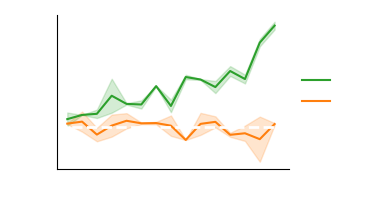


MODEL FIT

Train log likelihood: -279.150 [-619.491, -93.341]
Test log likelihood: -279.391 [-621.431, -94.497]
Train normalized log likelihood: 0.558 [0.483, 0.735]
Test normalized log likelihood: 0.558 [0.483, 0.737]

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (15 TRIAL HISTORY, INTERACTIONS) PARAMETERS



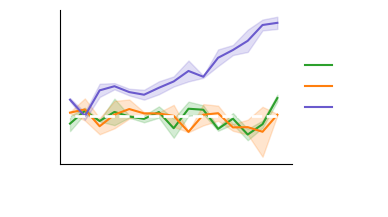


MODEL FIT

Train log likelihood: -275.566 [-615.704, -90.168]
Test log likelihood: -275.902 [-616.283, -91.112]
Train normalized log likelihood: 0.563 [0.482, 0.748]
Test normalized log likelihood: 0.563 [0.482, 0.746]

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (15 TRIAL HISTORY, MAIN EFFECTS) PARAMETERS



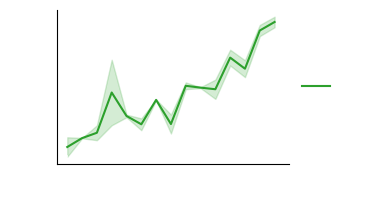


MODEL FIT

Train log likelihood: -279.205 [-619.394, -93.649]
Test log likelihood: -279.302 [-621.630, -94.353]
Train normalized log likelihood: 0.558 [0.483, 0.734]
Test normalized log likelihood: 0.558 [0.483, 0.738]

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (30 TRIAL HISTORY, MAIN EFFECTS) PARAMETERS



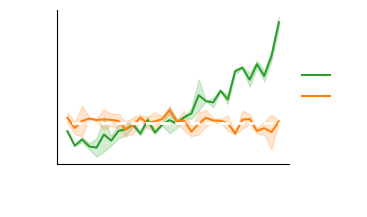


MODEL FIT

Train log likelihood: -276.636 [-612.972, -89.668]
Test log likelihood: -277.121 [-613.985, -90.138]
Train normalized log likelihood: 0.561 [0.487, 0.749]
Test normalized log likelihood: 0.561 [0.486, 0.748]

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (30 TRIAL HISTORY, INTERACTIONS) PARAMETERS



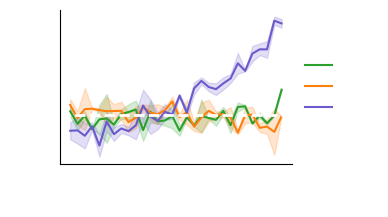


MODEL FIT

Train log likelihood: -273.071 [-605.796, -84.768]
Test log likelihood: -273.813 [-608.566, -83.090]
Train normalized log likelihood: 0.566 [0.486, 0.761]
Test normalized log likelihood: 0.566 [0.486, 0.760]

Loaded results from disk
ESTIMATED LOGISTIC REGRESSION (30 TRIAL HISTORY, MAIN EFFECTS) PARAMETERS



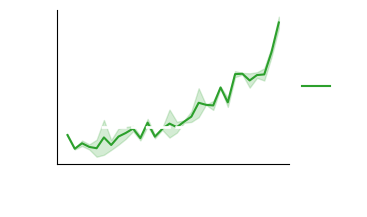


MODEL FIT

Train log likelihood: -276.731 [-612.702, -88.597]
Test log likelihood: -276.972 [-613.999, -90.327]
Train normalized log likelihood: 0.561 [0.487, 0.749]
Test normalized log likelihood: 0.561 [0.486, 0.747]



In [28]:
# SPLIT AND FIT THE DATA
recalculate = False

split_data = get_split_data()

# Parameters
for HISTORY_SIZE in [15,30]:#[10, 20, 30]:
    for MODE in ['cr_only', 'full', 'c_only']:

        # Check if the model has already been fit
        if os.path.isfile(fit_path+f'fit_results/logreg_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz') and recalculate == False:
            # Load the results from disk
            with gzip.open(fit_path+f'fit_results/logreg_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'rb') as f:
                all_data = pickle.load(f)
            print("Loaded results from disk")
            # Unpack the results
            models = all_data['models']
            train_probs = all_data['train_probs']
            test_probs = all_data['test_probs']
            train_log_liks = all_data['train_log_liks']
            test_log_liks = all_data['test_log_liks']
            train_norm_log_liks = all_data['train_norm_log_liks']
            test_norm_log_liks = all_data['test_norm_log_liks']
        
        # Otherwise, fit the model
        else:
            # Variables to store the results
            models = []
            train_probs = []
            test_probs = []
            train_log_liks = []
            test_log_liks = []
            train_norm_log_liks = []
            test_norm_log_liks = []

            # Fit the model to each split of the data
            for choices, rewards in split_data:
                # Fit the model
                model = fit_logreg(choices, rewards, HISTORY_SIZE, MODE)
                # Store the parameters
                models.append(model)
                # Compute the log likelihoods
                probs = predict_prob_logreg(choices, rewards, model, HISTORY_SIZE, MODE)
                train_probs.append(probs)
                train_log_liks.append(log_likelihood(probs, choices))
                train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

            # Test the model on the held-out data
            for n, (choices, rewards) in enumerate(split_data[::-1]):
                # Compute the log likelihoods
                probs = predict_prob_logreg(choices, rewards, models[n], HISTORY_SIZE, MODE)
                test_probs.append(probs)
                test_log_liks.append(log_likelihood(probs, choices))
                test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

            train_log_liks = np.concatenate(train_log_liks)
            test_log_liks = np.concatenate(test_log_liks)
            train_norm_log_liks = np.concatenate(train_norm_log_liks)
            test_norm_log_liks = np.concatenate(test_norm_log_liks)

            # Save to disk using compressed pickle format
            if not os.path.isdir(fit_path+'fit_results/'):
                os.mkdir(fit_path+'fit_results/')

            all_data = {
                'models': models,
                'train_probs': train_probs,
                'test_probs': test_probs,
                'train_log_liks': train_log_liks,
                'test_log_liks': test_log_liks,
                'train_norm_log_liks': train_norm_log_liks,
                'test_norm_log_liks': test_norm_log_liks
            }

            # Dump to disk
            with gzip.open(fit_path+f'fit_results/logreg_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'wb') as f:
                pickle.dump(all_data, f)

        # Parameters
        print("ESTIMATED LOGISTIC REGRESSION ({} TRIAL HISTORY, {}) PARAMETERS".format(HISTORY_SIZE, "INTERACTIONS" if MODE == 'full' else "MAIN EFFECTS"))
        print("=========================================================================")
        print()

        if MODE == 'full':
            names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
            colors = ['tab:green', 'tab:orange', 'slateblue', 'orchid']
        else:
            names = [r'$C$', r'$R$']
            colors = ['tab:green', 'tab:orange']

        # load the coefficients from shuffled data
        with open(fit_path+'fit_results/logreg_coefficients_{}_{}_shuffled.pkl'.format(HISTORY_SIZE,MODE), 'rb') as f:
            coefficients_shuffled = pickle.load(f)


        fig, ax = plt.subplots(figsize=(3, 2))
        for i in range(3 if MODE == 'full' else 2 if MODE == 'cr_only' else 1):
            coefs = []
            for j in range(2):
                temp = np.array_split(models[j].coef_[0], models[j].coef_[0].shape[0]//HISTORY_SIZE)[i]
                coefs.append(temp)
            
            coef_mean = np.mean(coefs, axis=0)
            coef_2_5 = np.percentile(coefs, 2.5, axis=0)
            coef_97_5 = np.percentile(coefs, 97.5, axis=0)

            # z-score the coefficients
            if z_score:
                coef_mean_shuffled = np.mean(coefficients_shuffled[i], axis=0)
                coef_std_shuffled = np.std(coefficients_shuffled[i], axis=0)
                coef_mean = (coef_mean - coef_mean_shuffled) / coef_std_shuffled
                coef_2_5 = (coef_2_5 - coef_mean_shuffled) / coef_std_shuffled
                coef_97_5 = (coef_97_5 - coef_mean_shuffled) / coef_std_shuffled
            
            ax.fill_between(range(HISTORY_SIZE), coef_2_5, coef_97_5, alpha=0.2, color=colors[i])
            ax.plot(range(HISTORY_SIZE), coef_mean, label=names[i], color=colors[i])

        # plot the zero line
        ax.axhline(0, color='white', linewidth=2, linestyle='--')

        ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
        ax.set_xlabel('Past Trials')
        ax.set_ylabel('Coefficient{}'.format(' (Z-Score)' if z_score else ''))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        plt.savefig('figures/logreg_{}_{}_coefficients.svg'.format(HISTORY_SIZE, MODE), format='svg', bbox_inches='tight')
        plt.show()

        # Summarize the results (mean and 95% CI)
        print("\nMODEL FIT")
        print("=========")
        print()
        print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
            train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
        print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
            test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
        print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
            train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
        print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
            test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
        print()

        # Add to models list
        all_models['LogReg{}({})'.format('CR' if  MODE=='cr_only' else 'Full' if MODE=='full' else 'C',HISTORY_SIZE)] = fit_path+f'fit_results/logreg_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz'

In [29]:
def get_probabilities(fly_no,return_trial_count=False):
    exp_name = metadata['Fly Experiment'][fly_no]
    exp_data = pd.read_csv(data_path+'experiments/'+exp_name)
    trial_count = sum(choice_data[fly_no,:] >= 0)
    # get probability of choosing reward for each odor
    p_1 = exp_data['P(R|O1)'].values[:trial_count]
    p_2 = exp_data['P(R|O2)'].values[:trial_count]
    if return_trial_count:
        return p_1, p_2, trial_count
    else:
        return p_1, p_2

def get_blocks(fly_no,return_n_blocks=False):
    """
    Get blocks for a given fly
    """
    p_1, p_2, trial_count = get_probabilities(fly_no,return_trial_count=True)
    # get block transitions
    block_transitions = np.logical_or(np.diff(p_1) != 0, np.diff(p_2) != 0)
    n_blocks = np.sum(block_transitions)
    block_transitions = np.concatenate(([0], block_transitions)) # account for first trial
    block_no = np.cumsum(block_transitions) # block number for each trial
    # loop over blocks
    block_data = []
    for b in np.unique(block_no):
        p_1_b = np.unique(p_1[block_no == b])[0]
        p_2_b = np.unique(p_2[block_no == b])[0]
        n_trials = np.sum(block_no == b)
        choices = choice_data[:,:trial_count][fly_no,block_no == b]
        rewards = reward_data[:,:trial_count][fly_no,block_no == b]
        block_length = np.sum(block_no == b)
        block_data.append({'p_1':p_1_b, 'p_2':p_2_b, 'choices':choices, 'rewards':rewards, 'block_length':block_length})
    return (block_data, n_blocks) if return_n_blocks else block_data

def bootstrap_c_coef(c, r, history_size, mode='full', n=10):
    """
    Bootstrap the coefficient for a given choice and reward dataset.
    """
    # calculate for shuffled data for z-scoring
    coefs = []
    for i in tqdm(range(n_shuffles)):
        c_ = [np.random.permutation(x) for x in c]
        r_ = [np.random.permutation(x) for x in r]
        model = fit_logreg(c_, r_, history_size, mode)
        coefs.append(np.array_split(model.coef_[0], model.coef_[0].shape[0]//history_size)[0])
    # reshape the coefficients
    coefficients_shuffled = []
    for i in range(len(coefs[0])):
        coefficients_shuffled.append(np.array([c[i] for c in coefs]))
    
    coefs = []
    for i in tqdm(range(n)):
        idx = np.random.choice(len(c), len(c))
        model = fit_logreg(c[idx], r[idx], history_size, mode)
        coef = np.array_split(model.coef_[0], model.coef_[0].shape[0]//history_size)[0]
        # z-score the coefficients
        coef_mean_shuffled = [np.mean(coefficients_shuffled[x], axis=0) for x in range(len(coefficients_shuffled))]
        coef_std_shuffled = [np.std(coefficients_shuffled[x], axis=0) for x in range(len(coefficients_shuffled))]
        coef = [(coef[x] - coef_mean_shuffled[x]) / coef_std_shuffled[x] for x in range(len(coef))]
        coefs.append(coef)
    return np.array(coefs)

def bootstrap_cr_coef(c, r, history_size, mode='full', n=10):
    """
    Bootstrap the coefficient for a given choice and reward dataset.
    """
    # calculate for shuffled data for z-scoring
    coefs = []
    for i in tqdm(range(n_shuffles)):
        c_ = [np.random.permutation(x) for x in c]
        r_ = [np.random.permutation(x) for x in r]
        model = fit_logreg(c_, r_, history_size, mode)
        coefs.append(np.array_split(model.coef_[0], model.coef_[0].shape[0]//history_size)[2])
    # reshape the coefficients
    coefficients_shuffled = []
    for i in range(len(coefs[0])):
        coefficients_shuffled.append(np.array([c[i] for c in coefs]))

    coefs = []
    for i in tqdm(range(n)):
        idx = np.random.choice(len(c), len(c))
        model = fit_logreg(c[idx], r[idx], history_size, mode)
        coef = np.array_split(model.coef_[0], model.coef_[0].shape[0]//history_size)[2]
        # z-score the coefficients
        coef_mean_shuffled = [np.mean(coefficients_shuffled[x], axis=0) for x in range(len(coefficients_shuffled))]
        coef_std_shuffled = [np.std(coefficients_shuffled[x], axis=0) for x in range(len(coefficients_shuffled))]
        coef = [(coef[x] - coef_mean_shuffled[x]) / coef_std_shuffled[x] for x in range(len(coef))]
        coefs.append(coef)
        
    return np.array(coefs)

In [30]:
recalculate = False
show_effects = False

MEDIAN BLOCK LENGTH: 45.0


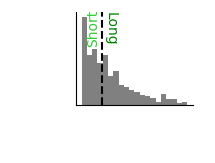

In [31]:
block_lengths = []
for i in range(N):
    block_data = get_blocks(i)[1:-1] # ignore first and last block (naive and final)
    block_lengths.append([b['block_length'] for b in block_data])
block_lengths = np.concatenate(block_lengths)

# Print the MEDIAN block length
MEDIAN_BLOCK_LENGTH = np.median(block_lengths)
print("MEDIAN BLOCK LENGTH: {}".format(np.median(block_lengths)))

plt.figure(figsize=(1.5,1.2))
plt.hist(block_lengths, bins=20, color='grey', alpha=1)
plt.axvline(MEDIAN_BLOCK_LENGTH, color='black', linestyle='--')
# add high and low block length labels
plt.text(MEDIAN_BLOCK_LENGTH-2, 450, 'Short', horizontalalignment='right', verticalalignment='center', rotation=90, color='limegreen')
plt.text(MEDIAN_BLOCK_LENGTH+2, 450, 'Long', horizontalalignment='left', verticalalignment='center', rotation=270, color='green')
plt.xlabel('Block Length', fontsize=14)
plt.ylabel('# Blocks', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.savefig('figures/split_block_length.svg', format='svg')
plt.show()

In [32]:
HISTORY_SIZE = 30

c_upper = []
c_lower = []
r_upper = []
r_lower = []

for j in tqdm(range(N)):
    blocks = get_blocks(j)
    for i in range(1,len(blocks)-1):
        c = blocks[i]['choices']
        r = blocks[i]['rewards']
        if blocks[i]['block_length']>MEDIAN_BLOCK_LENGTH:
            c_upper.append(c)
            r_upper.append(r)
        else:
            c_lower.append(c)
            r_lower.append(r)

c_upper = np.array(c_upper, dtype=object)
c_lower = np.array(c_lower, dtype=object)
r_upper = np.array(r_upper, dtype=object)
r_lower = np.array(r_lower, dtype=object)

# Load the results from disk
if os.path.isfile(fit_path+'fit_results/c_coef_bootstrap_block_length.pkl.gz') and recalculate == False:
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_block_length.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    c_coef_upper = all_data['c_coef_upper']
    c_coef_lower = all_data['c_coef_lower']
else:
    # Fit the model to each split of the data
    c_coef_upper = bootstrap_c_coef(c_upper, r_upper, HISTORY_SIZE, 'full',n=100)
    c_coef_lower = bootstrap_c_coef(c_lower, r_lower, HISTORY_SIZE, 'full',n=100)

    # save to disk
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'c_coef_upper': c_coef_upper,
        'c_coef_lower': c_coef_lower
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_block_length.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


  0%|          | 0/360 [00:00<?, ?it/s]

Loaded results from disk


In [33]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(c_coef_upper[:,i], c_coef_lower[:,i]))
effect_sizes = np.array(effect_sizes)

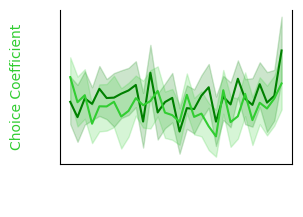

In [34]:
# Plot the results
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(range(HISTORY_SIZE), c_coef_upper.mean(axis=0), label='After Long Blocks', color='green')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_upper, 2.5, axis=0), np.percentile(c_coef_upper, 97.5, axis=0), alpha=0.2, color='green')
ax.plot(range(HISTORY_SIZE), c_coef_lower.mean(axis=0), label='After Short Block', color='limegreen')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_lower, 2.5, axis=0), np.percentile(c_coef_lower, 97.5, axis=0), alpha=0.2, color='limegreen')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Choice Coefficient', color='limegreen')
ax.spines['top'].set_visible(False)
if show_effects:
    # add a twin axis for the effect size
    ax2 = ax.twinx()
    ax2.plot(range(HISTORY_SIZE), effect_sizes, color='white', linewidth=1)
    ax2.scatter(range(HISTORY_SIZE), effect_sizes, s=[20 if np.abs(e)>2 else 0 for e in effect_sizes],c='white',zorder=10,marker='*')
    ax2.set_ylabel('Effect of Previous Block\n(Long - Short)', color='white',rotation=270,labelpad=20)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-6,15)

plt.savefig('figures/c_coef_block_length.svg', format='svg', bbox_inches='tight')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

In [35]:
recalculate = False

MEDIAN AVERAGE REWARD RATE: 0.38235294117647056


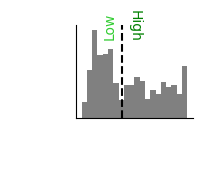

In [36]:
average_reward_rates = []
for i in range(N):
    block_data = get_blocks(i)[1:-1] # ignore first and last block (naive and final)
    average_reward_rates.append([np.mean(b['rewards']) for b in block_data])
average_reward_rates = np.concatenate(average_reward_rates)

# Print the MEDIAN average reward rate
MEDIAN_AVERAGE_REWARD_RATE = np.median(average_reward_rates)
print("MEDIAN AVERAGE REWARD RATE: {}".format(np.median(average_reward_rates)))

plt.figure(figsize=(1.5,1.2))
plt.hist(average_reward_rates, bins=20, color='grey', alpha=1)
plt.axvline(MEDIAN_AVERAGE_REWARD_RATE, color='black', linestyle='--')
# add high and low block length labels
plt.text(MEDIAN_AVERAGE_REWARD_RATE-0.05, 320, 'Low', horizontalalignment='right', verticalalignment='center', rotation=90, color='limegreen')
plt.text(MEDIAN_AVERAGE_REWARD_RATE+0.05, 320, 'High', horizontalalignment='left', verticalalignment='center', rotation=270, color='green')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Reward Rate', fontsize=14)
plt.ylabel('# Blocks', fontsize=14)
# plt.title('Average Reward Rate Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.savefig('figures/split_average_reward_rate.svg', format='svg')
plt.show()

In [37]:
HISTORY_SIZE = 30

c_high = []
c_low = []
r_high = []
r_low = []

for j in tqdm(range(N)):
    blocks = get_blocks(j)
    for i in range(1,len(blocks)-1):
        c = blocks[i]['choices']
        r = blocks[i]['rewards']
        if np.mean(blocks[i-1]['rewards'])>MEDIAN_AVERAGE_REWARD_RATE:
            c_high.append(c)
            r_high.append(r)
        else:
            c_low.append(c)
            r_low.append(r)

c_high = np.array(c_high, dtype=object)
c_low = np.array(c_low, dtype=object)
r_high = np.array(r_high, dtype=object)
r_low = np.array(r_low, dtype=object)

# Load the results from disk
if os.path.isfile(fit_path+'fit_results/c_coef_bootstrap_previous_rewards.pkl.gz') and recalculate == False:
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_previous_rewards.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    c_coef_high = all_data['c_coef_high']
    c_coef_low = all_data['c_coef_low']
else:
    # Fit the model to each split of the data
    c_coef_high = bootstrap_c_coef(c_high, r_high, HISTORY_SIZE, 'full',n=100)
    c_coef_low = bootstrap_c_coef(c_low, r_low, HISTORY_SIZE, 'full',n=100)

    # save to disk
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'c_coef_high': c_coef_high,
        'c_coef_low': c_coef_low
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_previous_rewards.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


  0%|          | 0/360 [00:00<?, ?it/s]

Loaded results from disk


In [38]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(c_coef_high[:,i], c_coef_low[:,i]))
effect_sizes = np.array(effect_sizes)

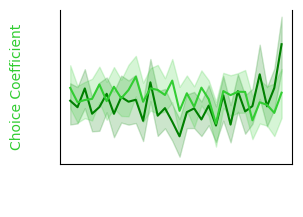

In [39]:
# Plot the results
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(range(HISTORY_SIZE), c_coef_high.mean(axis=0), label='High Reward Rate', color='green')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_high, 2.5, axis=0), np.percentile(c_coef_high, 97.5, axis=0), alpha=0.2, color='green')
ax.plot(range(HISTORY_SIZE), c_coef_low.mean(axis=0), label='Low Reward Rate', color='limegreen')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_low, 2.5, axis=0), np.percentile(c_coef_low, 97.5, axis=0), alpha=0.2, color='limegreen')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Choice Coefficient', color='limegreen')
ax.spines['top'].set_visible(False)
if show_effects:
    # add a twin axis for the effect size
    ax2 = ax.twinx()
    ax2.plot(range(HISTORY_SIZE), effect_sizes, color='white', linewidth=1)
    ax2.scatter(range(HISTORY_SIZE), effect_sizes, s=[20 if np.abs(e)>2 else 0 for e in effect_sizes],c='white',zorder=10,marker='*')
    ax2.set_ylabel('Effect of Past Reward\n(High - Low)', color='white',rotation=270,labelpad=20)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-12,6)
plt.savefig('figures/c_coef_previous_rewards.svg', format='svg', bbox_inches='tight')
plt.show()

In [40]:
recalculate = False

In [41]:
HISTORY_SIZE = 30

c_high = []
c_low = []
r_high = []
r_low = []

for j in tqdm(range(N)):
    blocks = get_blocks(j)
    for i in range(1,len(blocks)-1):
        c = blocks[i]['choices']
        r = blocks[i]['rewards']
        if np.mean(blocks[i-1]['rewards'])>MEDIAN_AVERAGE_REWARD_RATE:
            c_high.append(c)
            r_high.append(r)
        else:
            c_low.append(c)
            r_low.append(r)

c_high = np.array(c_high, dtype=object)
c_low = np.array(c_low, dtype=object)
r_high = np.array(r_high, dtype=object)
r_low = np.array(r_low, dtype=object)

# Load the results from disk
if os.path.isfile(fit_path+'fit_results/cr_coef_bootstrap_previous_rewards.pkl.gz') and recalculate == False:
    with gzip.open(fit_path+'fit_results/cr_coef_bootstrap_previous_rewards.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    cr_coef_high = all_data['cr_coef_high']
    cr_coef_low = all_data['cr_coef_low']
else:
    # Fit the model to each split of the data
    cr_coef_high = bootstrap_cr_coef(c_high, r_high, HISTORY_SIZE, 'full',n=100)
    cr_coef_low = bootstrap_cr_coef(c_low, r_low, HISTORY_SIZE, 'full',n=100)

    # save to disk
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'cr_coef_high': cr_coef_high,
        'cr_coef_low': cr_coef_low
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/cr_coef_bootstrap_previous_rewards.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


  0%|          | 0/360 [00:00<?, ?it/s]

Loaded results from disk


In [42]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(cr_coef_high[:,i], cr_coef_low[:,i]))
effect_sizes = np.array(effect_sizes)

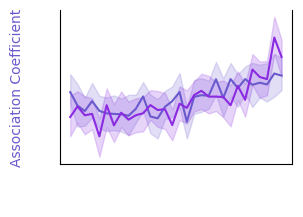

In [43]:
# Plot the results
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(range(HISTORY_SIZE), cr_coef_high.mean(axis=0), label='High Reward Rate', color='slateblue')
ax.fill_between(range(HISTORY_SIZE), np.percentile(cr_coef_high, 2.5, axis=0), np.percentile(cr_coef_high, 97.5, axis=0), alpha=0.2, color='slateblue')
ax.plot(range(HISTORY_SIZE), cr_coef_low.mean(axis=0), label='Low Reward Rate', color='blueviolet')
ax.fill_between(range(HISTORY_SIZE), np.percentile(cr_coef_low, 2.5, axis=0), np.percentile(cr_coef_low, 97.5, axis=0), alpha=0.2, color='blueviolet')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Association Coefficient', color='slateblue')
ax.spines['top'].set_visible(False)
if show_effects:
    # add a twin axis for the effect size
    ax2 = ax.twinx()
    ax2.plot(range(HISTORY_SIZE), effect_sizes, color='white', linewidth=1)
    ax2.scatter(range(HISTORY_SIZE), effect_sizes, s=[20 if np.abs(e)>2 else 0 for e in effect_sizes],c='white',zorder=10,marker='*')
    ax2.set_ylabel('Effect of Past Reward\n(High - Low)', color='white',rotation=270,labelpad=20)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-12,6)
plt.savefig('figures/cr_coef_previous_rewards.svg', format='svg', bbox_inches='tight')
plt.show()

In [47]:
recalculate = False

MEDIAN BLOCK COUNT: 8.0


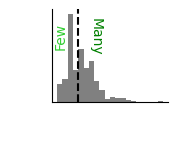

In [48]:
n_blocks = []
for i in range(N):
    _,n_block = get_blocks(i,return_n_blocks=True)
    n_blocks.append(n_block)
n_blocks = np.array(n_blocks)

# Print the MEDIAN average reward rate
MEDIAN_BLOCK_COUNT = np.median(n_blocks)
print("MEDIAN BLOCK COUNT: {}".format(np.median(n_blocks)))

plt.figure(figsize=(1.5,1.2))
plt.hist(n_blocks, bins=20, color='grey', alpha=1)
plt.axvline(MEDIAN_BLOCK_COUNT, color='black', linestyle='--')
# add high and low block length labels
plt.text(MEDIAN_BLOCK_COUNT-3, 70, 'Few', horizontalalignment='right', verticalalignment='center', rotation=90, color='limegreen')
plt.text(MEDIAN_BLOCK_COUNT+3, 70, 'Many', horizontalalignment='left', verticalalignment='center', rotation=270, color='green')
plt.xlabel('Block Count')
plt.ylabel('# Flies')
# plt.title('Average Reward Rate Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.savefig('figures/split_block_count.svg', format='svg')
plt.show()

In [49]:
HISTORY_SIZE = 30
MIN_TRIALS = 100
c_high = []
c_low = []
r_high = []
r_low = []

for j in tqdm(range(N)):
    c = get_valid_data(choice_data[j,:])[MIN_TRIALS:]
    r = get_valid_data(reward_data[j,:])[MIN_TRIALS:]
    if n_blocks[j]>MEDIAN_BLOCK_COUNT:   
        c_high.append(c)
        r_high.append(r)
    else:
        c_low.append(c)
        r_low.append(r)

c_high = np.array(c_high, dtype=object) 
c_low = np.array(c_low, dtype=object)
r_high = np.array(r_high, dtype=object)
r_low = np.array(r_low, dtype=object)

# Load the results from disk
if os.path.isfile(fit_path+'fit_results/c_coef_bootstrap_n_blocks.pkl.gz') and recalculate == False:
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_n_blocks.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    c_coef_high = all_data['c_coef_high']
    c_coef_low = all_data['c_coef_low']
else:
    # Fit the model to each split of the data
    c_coef_high = bootstrap_c_coef(c_high, r_high, HISTORY_SIZE, 'full',n=100)
    c_coef_low = bootstrap_c_coef(c_low, r_low, HISTORY_SIZE, 'full',n=100)

    # save to disk
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'c_coef_high': c_coef_high,
        'c_coef_low': c_coef_low
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_n_blocks.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


  0%|          | 0/360 [00:00<?, ?it/s]

Loaded results from disk


In [50]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(c_coef_high[:,i], c_coef_low[:,i]))
effect_sizes = np.array(effect_sizes)

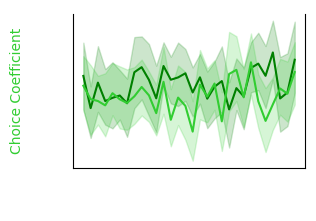

In [51]:
# Plot the results
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(range(HISTORY_SIZE), c_coef_high.mean(axis=0), label='High Reward Rate', color='green')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_high, 2.5, axis=0), np.percentile(c_coef_high, 97.5, axis=0), alpha=0.2, color='green')
ax.plot(range(HISTORY_SIZE), c_coef_low.mean(axis=0), label='Low Reward Rate', color='limegreen')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_low, 2.5, axis=0), np.percentile(c_coef_low, 97.5, axis=0), alpha=0.2, color='limegreen')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Choice Coefficient', color='limegreen')
ax.spines['top'].set_visible(False)

if show_effects:
    # add a twin axis for the effect size
    ax2 = ax.twinx()
    ax2.plot(range(HISTORY_SIZE), effect_sizes, color='white', linewidth=1)
    ax2.scatter(range(HISTORY_SIZE), effect_sizes, s=[20 if np.abs(e)>2 else 0 for e in effect_sizes],c='white',zorder=10,marker='*')
    ax2.set_ylabel('Effect of # Blocks\n(Many - Few)', color='white')
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-5,14)
plt.savefig('figures/c_coef_n_blocks.svg', format='svg', bbox_inches='tight')
plt.show()

In [52]:
HISTORY_SIZE = 30

c_fast = []
c_slow = []
r_fast = []
r_slow = []

for j in tqdm(range(N)):
    # get choice, reward, and trial duration data
    c = get_valid_data(choice_data[j,:])
    r = get_valid_data(reward_data[j,:])
    t = trial_duration_data[j,:][~np.isnan(trial_duration_data[j,:])]
    # get rolling average of trial durations (50 trials)
    t = np.convolve(t, np.ones(50)/50, mode='full')[50:len(t)]
    t_mid = np.median(t)
    idx = np.where(t<t_mid)[0][0] + 50
    c_fast.append(c[idx:])
    r_fast.append(r[idx:])
    c_slow.append(c[:idx])
    r_slow.append(r[:idx])

c_fast = np.array(c_fast, dtype=object)
c_slow = np.array(c_slow, dtype=object)
r_fast = np.array(r_fast, dtype=object)
r_slow = np.array(r_slow, dtype=object)


# Load the results from disk
if os.path.isfile(fit_path+'fit_results/c_coef_bootstrap_trial_duration.pkl.gz') and recalculate == False:
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_trial_duration.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    c_coef_fast = all_data['c_coef_fast']
    c_coef_slow = all_data['c_coef_slow']
else:
    # Fit the model to each split of the data
    c_coef_fast = bootstrap_c_coef(c_fast, r_fast, HISTORY_SIZE, 'full',n=100)
    c_coef_slow = bootstrap_c_coef(c_slow, r_slow, HISTORY_SIZE, 'full',n=100)

    # save to disk
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'c_coef_fast': c_coef_fast,
        'c_coef_slow': c_coef_slow
    }

    # Dump to disk
    with gzip.open(fit_path+'fit_results/c_coef_bootstrap_trial_duration.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)


  0%|          | 0/360 [00:00<?, ?it/s]

Loaded results from disk


In [53]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(c_coef_fast[:,i], c_coef_slow[:,i]))
effect_sizes = np.array(effect_sizes)

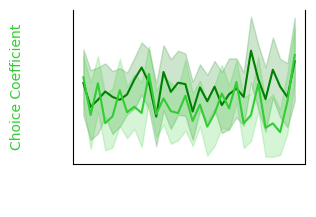

In [54]:
# Plot the results
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(range(HISTORY_SIZE), c_coef_fast.mean(axis=0), label='Fast Trial Period', color='green')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_fast, 2.5, axis=0), np.percentile(c_coef_fast, 97.5, axis=0), alpha=0.2, color='green')
ax.plot(range(HISTORY_SIZE), c_coef_slow.mean(axis=0), label='Slow Trials Period', color='limegreen')
ax.fill_between(range(HISTORY_SIZE), np.percentile(c_coef_slow, 2.5, axis=0), np.percentile(c_coef_slow, 97.5, axis=0), alpha=0.2, color='limegreen')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Choice Coefficient', color='limegreen')
ax.spines['top'].set_visible(False)

if show_effects:
    # add a twin axis for the effect size
    ax2 = ax.twinx()
    ax2.plot(range(HISTORY_SIZE), effect_sizes, color='white', linewidth=1)
    ax2.scatter(range(HISTORY_SIZE), effect_sizes, s=[20 if np.abs(e)>2 else 0 for e in effect_sizes],c='white',zorder=10,marker='*')
    ax2.set_ylabel('Effect of Trial Rapidity\n(Fast - Slow)', color='white')
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-5,14)
plt.savefig('figures/c_coef_trial_durations.svg', format='svg', bbox_inches='tight')
plt.show()

### Estimating the upper bound of the explainable variance

For sequential models, Recurrent Neural Networks (RNNs) provide a natural way to model the temporal dependencies between the input and output sequences. However, the recurrent nature of these models makes it difficult to interpret the learned representations. However, they can provide a good upper bound on the explainable variance.

We shall use [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (Long Short-Term Memory) networks to model the temporal dependencies between the input and output sequences. LSTM networks are a special kind of RNN, capable of learning long-term dependencies. 

We shall use the [PyTorch](https://pytorch.org/) library to implement the LSTM network. We shall also find the optimal hyperparameters for the LSTM network using the Hyperopt library.


In [55]:
recalculate = False

In [56]:
# Setup a LSTM model for cognitive analysis
class CogLSTM(nn.Module):
    """
    LSTM model for cognitive analysis (matched size seq-to-seq task)
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, expansions=[], mixing_ratio=0.85):
        """
        Initialize the model
        
        Parameters
        ----------
        input_size: int
            The size of the input
        hidden_size: int
            The size of the hidden units
        num_layers: int
            The number of layers
        output_size: int
            The size of the output
        expansion: list, optional (default=[])
            The expansion factors before the LSTM layer
        mixing_ratio: float
            The mixing ratio for the hard sigmoid and sigmoid activation functions
        """
        super(CogLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.expansions = expansions
        self.input_size = input_size

        if len(expansions) > 0:
            self.expansion_layers = nn.Sequential()
            for i in range(len(expansions)):
                self.expansion_layers.add_module('expansion_{}'.format(i), nn.Linear(input_size, int(input_size*expansions[i])))
                # add a non-linearity and update the input size
                self.expansion_layers.add_module('expansion_{}_relu'.format(i), nn.ReLU())
                input_size = int(input_size*expansions[i])

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.mixing_ratio = mixing_ratio

        # Initialize the weights
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        for name, param in self.fc.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, 0.0, 0.001)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)


    def forward(self, x):
        """
        Forward pass
        
        Parameters
        ----------
        x: torch.Tensor
            The input tensor
        
        Returns
        -------
        torch.Tensor
            The output tensor
        """
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Pass the input through the expansion layers
        if len(self.expansions) > 0:
            x = self.expansion_layers(x)
            
        # Forward propagate LSTM (x: batch, seq_len, input_size)
        x, _ = self.lstm(x, (h0, c0))

        # Pass each hidden state through the fully connected layer
        x = self.fc(x)

        # pass through a hard sigmoid + sigmoid activation function
        x = (1-self.mixing_ratio)*F.hardsigmoid(x) + self.mixing_ratio*F.sigmoid(x)
        return x
    
    def train_model(
            self, 
            train_loader, 
            val_loader, 
            num_epochs, 
            learning_rate, 
            patience, 
            weight_decay=1e-5,
            schedule_lr=False, 
            device=device, verbose=True):
        """
        Train the model
        
        Parameters
        ----------
        train_loader: torch.utils.data.DataLoader
            The training data loader
        val_loader: torch.utils.data.DataLoader
            The validation data loader
        num_epochs: int
            The number of epochs
        learning_rate: float
            The learning rate
        patience: int
            The number of epochs to wait before early stopping
        weight_decay: float, optional (default=1e-5)
            The weight decay for the optimizer
        schedule_lr: bool, optional (default=False)
            Whether to schedule the learning rate
        device: torch.device
            The device to run the model on
        verbose: bool, optional (default=True)
            Whether to print the training and validation losses
        """
        # Define the loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        if schedule_lr:
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience//2, verbose=True)

        # Move the model to the device
        self.to(device)

        # Track the training and validation losses
        train_losses = []
        val_losses = []

        # Early stopping parameters
        best_val_loss = np.inf
        best_model = None
        epochs_no_improve = 0

        # Train the LSTM model with Early Stopping
        total_step = len(train_loader)
        for epoch in range(num_epochs):
            # get the training data
            train_loss_sum = 0
            self.train()
            for i, (input_seq, target_seq) in enumerate(train_loader):
                # Move tensors to the configured device
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                # Forward pass
                outputs = self(input_seq)
                loss = criterion(outputs, target_seq)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Record the training loss
                train_loss_sum += loss.item()
            
            train_losses.append(train_loss_sum/total_step)

            # Update the learning rate if necessary
            if schedule_lr:
                lr_scheduler.step(train_losses[-1])

            # Evaluate the model on the validation set using CrossEntropyLoss
            self.eval()
            with torch.no_grad():
                test_loss_sum = 0
                for i, (input_seq, target_seq) in enumerate(val_loader):
                    # Move tensors to the configured device
                    input_seq = input_seq.to(device)
                    target_seq = target_seq.to(device)

                    # Forward pass
                    outputs = self(input_seq)
                    loss = criterion(outputs, target_seq)
                    test_loss_sum += loss.item()

            val_losses.append(test_loss_sum/len(val_loader))

            # Print the training loss and validation loss every 10 epochs
            if (epoch+1) % 10 == 0 and verbose:
                print ('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, train_loss_sum/total_step, test_loss_sum/len(val_loader)))
                
            
            # Early stopping with patience
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                epochs_no_improve = 0
                best_model = copy.deepcopy(self.state_dict())
                
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience and verbose:
                    print('Early stopping! Epochs with no improvement: {}'.format(patience))
                    self.load_state_dict(best_model)
                    break

        # Return the training and validation losses
        return train_losses, val_losses
    
    def save_model(self, path):
        """
        Save the model and architecture to a file
        
        Parameters
        ----------
        path: str
            The path to save the model
        """
        # save the model
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Load the model from a file
        
        Parameters
        ----------
        path: str
            The path to load the model from
        """
        # load the model
        self.load_state_dict(torch.load(path))
    
    def get_model_name(self):
        """
        Get the model name
        
        Returns
        -------
        str
            The model name
        """
        if len(self.expansions) == 0:
            exp_str = '['
            temp = self.input_size
            for i in range(len(self.expansions)):
                exp_str += str(temp) + 'x'
                temp = int(temp*self.expansions[i])
            exp_str += str(temp) + ']'
            name = 'CogLSTM'+exp_str+'x('+str(self.hidden_size)+'r)x'+str(self.num_layers)
        else:
            name = 'CogLSTM('+str(self.hidden_size)+'r)x'+str(self.num_layers)
        return name

In [57]:
def get_input_data(choices, rewards, max_seq_length=1400):
    """
    Creates the dataset for the model

    Parameters
    ----------

    choices : list
        List of choices
    rewards : list
        List of rewards
    max_seq_length : int
        Maximum sequence length to use for training and testing
    """
    Xs = []
    ys = []

    for c,r in zip(choices, rewards):
        # scale to [-1,1]
        c_ = (c-0.5)*2
        r_ = r
        # add a zero in the beginning and pad to MAX_SEQ_LENGTH
        c_ = np.concatenate([[0], c_, np.zeros(max_seq_length-len(c_))])
        r_ = np.concatenate([[0], r_, np.zeros(max_seq_length-len(r_))])
        # create interactions
        i_ = c_ * r_
        # Create X by stacking all interactions with choices and rewards
        X = np.vstack([c_,r_,i_]).T[:-1]
        Xs.append(X)
        # Create y with the next choice
        y = np.concatenate([c, 0.5*np.ones(max_seq_length-len(c))])
        ys.append(y.reshape(-1,1))

    Xs = np.array(Xs)
    ys = np.array(ys)
    
    # convert to torch tensors
    Xs = torch.from_numpy(Xs).float()
    ys = torch.from_numpy(ys).float()

    return Xs, ys

def get_dataloader(choices, rewards, train_test_split=0.8, max_seq_length=1200, return_xy=False):
    """
    Creates dataloaders for training and testing
    
    Parameters
    ----------
    choices : list
        List of choices
    rewards : list
        List of rewards
    train_test_split : float
        Percentage of data to use for training
    max_seq_length : int
        Maximum sequence length to use for training and testing
    return_xy : bool
        Whether to return X and y with dataloaders or dataloaders only
    """
    Xs, ys = get_input_data(choices, rewards, max_seq_length=max_seq_length)

    # randomize order
    idx = np.random.permutation(len(Xs))
    Xs = Xs[idx]
    ys = ys[idx]
    
    # split into train and test
    Xs_train = Xs[:int(train_test_split*len(Xs))]
    ys_train = ys[:int(train_test_split*len(ys))]
    Xs_test = Xs[int(train_test_split*len(Xs)):]
    ys_test = ys[int(train_test_split*len(ys)):]

    # create dataloaders
    train_dataset = TensorDataset(Xs_train, ys_train)
    test_dataset = TensorDataset(Xs_test, ys_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    if return_xy:
        return train_loader, test_loader, Xs, ys
    else:
        return train_loader, test_loader


In [58]:
# SPLIT AND FIT THE DATA
split_data = get_split_data()

# Parameters
params = [
    (32, 2, [2,2]),
    (128, 1, [2,2]),
]

for HIDDEN_SIZE, NUM_LAYERS, EXPANSIONS in params:

    architecture = {
        'hidden_size': HIDDEN_SIZE, # number of hidden units
        'num_layers': NUM_LAYERS, # number of RNN layers
        'expansions': EXPANSIONS, # expansion factors before the LSTM layer
    }

    test_model = CogLSTM(
        input_size=3,
        output_size=1, 
        **architecture
    )
    name = test_model.get_model_name()

    # Training parameters
    TRAIN_TEST_SPLIT = 0.8
    MAX_SEQ_LENGTH = 1500
    NUM_EPOCHS = 10000
    LEARNING_RATE = 0.0001
    PATIENCE = 150
    WEIGHT_DECAY = 0.001

    # check if model has already been fit
    if os.path.isfile(fit_path+f'fit_results/{name}_fit_results.pkl.gz') and recalculate == False:
        # Load the results
        with gzip.open(fit_path+f'fit_results/{name}_fit_results.pkl.gz', 'rb') as f:
            all_data = pickle.load(f)
        print("Loaded results from disk")
        # Unpack the results
        params = all_data['params']
        train_log_liks = all_data['train_log_liks']
        test_log_liks = all_data['test_log_liks']
        train_norm_log_liks = all_data['train_norm_log_liks']
        test_norm_log_liks = all_data['test_norm_log_liks']
        train_probs = all_data['train_probs']
        test_probs = all_data['test_probs']

    # Otherwise, fit the model
    else:   
        # Variables to store the results
        params = []
        train_probs = []
        test_probs = []
        train_log_liks = []
        test_log_liks = []
        train_norm_log_liks = []
        test_norm_log_liks = []

        # Fit the model to each split of the data
        for choices, rewards in split_data:
            # Get the dataloaders
            train_dataloader, test_dataloader, X, y = get_dataloader(choices, rewards, TRAIN_TEST_SPLIT, MAX_SEQ_LENGTH, return_xy=True)
            # Define the model
            cog_lstm = CogLSTM(
                input_size=3,
                output_size=1, 
                **architecture
            )
            # Train the model
            train_losses, test_losses = cog_lstm.train_model(
                                            train_dataloader,
                                            test_dataloader,
                                            num_epochs=NUM_EPOCHS,
                                            learning_rate=LEARNING_RATE,
                                            patience=PATIENCE,
                                            weight_decay=WEIGHT_DECAY,
                                            schedule_lr=False,
                                            device=device
            )
            # Store the state dict
            params.append((architecture, cog_lstm.state_dict()))
            # Compute the log likelihoods
            temp_probs = cog_lstm(X).squeeze().detach().numpy()
            probs = []
            for i in range(len(choices)):
                temp = temp_probs[i, :len(choices[i])]
                probs.append(temp)
            probs = np.array(probs,dtype=object)
            train_probs.append(probs)
            train_log_liks.append(log_likelihood(probs, choices))
            train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

        # Test the model on the held-out data
        for n, (choices, rewards) in enumerate(split_data[::-1]):
            # get X and y
            X,y = get_input_data(choices, rewards, MAX_SEQ_LENGTH)
            # Get the model
            cog_lstm = CogLSTM(
                input_size=3,
                output_size=1, 
                **params[n][0]
            )
            # Load the state dict
            cog_lstm.load_state_dict(params[n][1])
            # Compute the log likelihoods
            temp_probs = cog_lstm(X).squeeze().detach().numpy()
            probs = []
            for i in range(len(choices)):
                temp = temp_probs[i, :len(choices[i])]
                probs.append(temp)
            probs = np.array(probs,dtype=object)
            test_probs.append(probs)
            test_log_liks.append(log_likelihood(probs, choices))
            test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

        train_log_liks = np.concatenate(train_log_liks)
        test_log_liks = np.concatenate(test_log_liks)
        train_norm_log_liks = np.concatenate(train_norm_log_liks)
        test_norm_log_liks = np.concatenate(test_norm_log_liks)

        # Save to disk using compressed pickle format
        if not os.path.isdir(fit_path+'fit_results/'):
            os.mkdir(fit_path+'fit_results/')

        all_data = {
            'params': params,
            'train_log_liks': train_log_liks,
            'test_log_liks': test_log_liks,
            'train_norm_log_liks': train_norm_log_liks,
            'test_norm_log_liks': test_norm_log_liks,
            'train_probs': train_probs,
            'test_probs': test_probs
        }

        # Dump to disk
        with gzip.open(fit_path+f'fit_results/{name}_fit_results.pkl.gz', 'wb') as f:
            pickle.dump(all_data, f)

    # Summarize the results (mean and 95% CI)
    print("\nMODEL FIT")
    print("=========")
    print()
    print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
    print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
    print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
    print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))

    # Add to models list
    all_models[name] = fit_path+f'fit_results/{name}_fit_results.pkl.gz'

Loaded results from disk

MODEL FIT

Train log likelihood: -360.080 [-665.416, -150.097]
Test log likelihood: -278.239 [-612.040, -98.596]
Train normalized log likelihood: 0.463 [0.315, 0.571]
Test normalized log likelihood: 0.559 [0.489, 0.717]
Loaded results from disk

MODEL FIT

Train log likelihood: -370.739 [-712.361, -148.754]
Test log likelihood: -275.202 [-609.322, -82.718]
Train normalized log likelihood: 0.452 [0.270, 0.571]
Test normalized log likelihood: 0.563 [0.487, 0.735]


Here, we can see that the LSTM does not necessarily perform better than the previous simpler models. This could be become of incomplete training or under/over parameterization making it a hard learning problem. However there are many individual examples where the LSTM performs better than other models, which could suggest the individual variability of the data is a factor in the performance of the LSTM. Maybe a larger dataset will help the LSTM perform better.

### Reinforcement Learning as an Interpretable Cognitive Model

Now that we have a baseline of how well simple models like Win-Stay-Lose-Go, and Temporal Logistic Regression Models and complex models like LSTM perform on the task of predicting the next action given the past experience, we can now compare these to various forms of Q-Learning methods to see how well they predict the fly's next action.

The models are defined under pygorl.cogq. Note that these are all 1-state problems and rewards are binary (0 or 1).

The general structure of the models is as follows:

#### Q-Learning Methods

$$
\begin{gather}
\text{Initialize } Q_0(a) = q_{a,0} \text{ for all } a \in \mathcal{A} \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } Q_t(a) \text{ as follows:} \\
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_{learn} \cdot (R_t + (1-R_t)\cdot \kappa - Q_t(a_t)) \text{, if } a_t \text{ is chosen} \\
Q_{t+1}(a) = Q_t(a) - \alpha_{forget} \cdot Q_t(a) \text{, for all } a \neq a_t
\end{gather}
$$

Note that over here $q_{a,0}$ is the initial value of the Q-Value for action $a$, $\alpha_{learn}$ is the learning rate, $\alpha_{forget}$ is the forgetting rate, and $\kappa$ is the perceived reward for performing the action itself irrespective of the outcome. All these parameters are learned from the data. The actions are calculated using a softmax function as follows:

$$
\begin{gather}
\text{For each trial } t \text{, } \text{calculate } \pi_t(a) = \frac{e^{Q_t(a)}}{\sum_{a'} e^{Q_t(a')}} \text{, for all } a \in \mathcal{A} \\
\text{Choose } a_t \text{ with probability } \pi_t(a_t) \text{, for all } a \in \mathcal{A}
\end{gather}
$$

### Understanding the Q-Update Variants

| Variant | $\alpha_{learn}$ | $\alpha_{forget}$ | $\kappa$ |
| --- | --- | --- | --- |
| Vanilla Q-Learning | Learned from data | 0 | 0 |
| Q-Learning with forgetting | Learned from data | Learned from data | 0 |
| Q-Learning with omission sensitivity | Learned from data | 0 | Learned from data |
| Q-Learning with forgetting and omission sensitivity | Learned from data | Learned from data | Learned from data |
| Q-Learning with forgetting and q-scaled omission sensitivity | Learned from data | Learned from data | $\kappa=\kappa_0 \cdot q_{t}(a_t)$  $\kappa_0$ learned from data |






In [59]:
# Model Details

q_models = [
    {
        'name': 'Q-Learning',
        'class': QLearning,
        'addl': {},
        'dir': fit_path+'fit_results/QL_2cv_de_20231003.pkl'
    },
    {
        'name': 'Q-Learning with Forgetting',
        'class': FQLearning,
        'addl': {},
        'dir': fit_path+'fit_results/FQL_2cv_de_20231003.pkl'
    },
    {
        'name': 'Q-Learning with Omission Sensitivity',
        'class': OSQLearning,
        'addl': {},
        'dir': fit_path+'fit_results/OSQL_2cv_de_20231003.pkl'
    },
    {
        'name': 'Q-Learning with Forgetting and Omission Sensitivity',
        'class': OSFQLearning,
        'addl': {},
        'dir': fit_path+'fit_results/OSFQL_2cv_de_20231013.pkl'
    },
    {
        'name': 'Q-Learning with Forgetting and Q-scaled Omission Sensitivity',
        'class': SOSFQLearning,
        'addl': {},
        'dir': fit_path+'fit_results/SOSFQL_2cv_de_20231003.pkl'
    },
]

In [60]:
# HELPER FUNCTIONS

def generate_dynamical_plot(
        model,
        params,
        name,
        max_val = 1.1,
        min_val = -0.1,
        resolution = 50
):
    # remove the initial q values
    params = np.array(params)[2:]

    # generate the meshgrid
    x = np.linspace(min_val,max_val,resolution)
    y = np.linspace(min_val,max_val,resolution)
    X,Y = np.meshgrid(x,y)

    # generate the vector field
    Z = np.zeros((resolution,resolution,2))

    fig, ax = plt.subplots(1,4,figsize=(10,3),sharex=True,sharey=True)
    for index,(C,R) in enumerate([[0,0],[0,1],[1,0],[1,1]]):
        for i in range(resolution):
            for j in range(resolution):
                Z[i,j] = model.q_update([X[i,j],Y[i,j]],C,R,params)-np.array([X[i,j],Y[i,j]])
        magnitude = np.sqrt(Z[:,:,0]**2+Z[:,:,1]**2)
        ax[index].streamplot(X,Y,Z[:,:,0],Z[:,:,1],color=magnitude,linewidth=1,cmap=plt.cm.RdYlGn)
        ax[index].imshow(np.log(magnitude),extent=[min_val,max_val,min_val,max_val],origin='lower',cmap=plt.cm.RdYlGn)
        ax[index].set_xlabel(r'$Q_1$',fontsize=16)
        ax[index].set_ylabel(r'$Q_2$',fontsize=16)
        ax[index].set_title(f'Odor {C+1} Chosen\n{"Rewarded" if R==1 else "Unrewarded"}',fontsize=16)
        ax[index].set_aspect('equal', adjustable='box')
        ax[index].set_xticks([0,1])
        ax[index].set_yticks([0,1])
        ax[index].set_xticklabels([0,1],fontsize=16)
        ax[index].set_yticklabels([0,1],fontsize=16)
    # plt.suptitle(f'Dynamical Map for {name}')
    plt.tight_layout()
    plt.savefig(f'figures/dynamical_map_{name}.svg', format='svg', bbox_inches='tight')
    plt.show()

def generate_update_plot(
        model,
        params,
        name,
        max_val = 1.1,
        min_val = -0.1,
        resolution = 50
):
    # remove the initial q values
    params = np.array(params)[2:]

    # generate the meshgrid
    x = np.linspace(min_val,max_val,resolution)
    y = np.linspace(min_val,max_val,resolution)
    X,Y = np.meshgrid(x,y)

    # generate the vector field
    Z = np.zeros((resolution,resolution,2))

    fig, ax = plt.subplots(2,4,figsize=(9,4),sharex=True,sharey=True)
    for index,(C,R) in enumerate([[0,0],[0,1],[1,0],[1,1]]):
        for j in np.linspace(min_val,max_val,resolution):
            x,y = [],[]
            for i in np.linspace(min_val,max_val,resolution):
                x.append(i)
                y.append(model.q_update([i,j],C,R,params)[0])
            ax[0,index].plot(x,y,color=plt.cm.viridis((j-min_val)/(max_val-min_val)))
            # find every point where the y crosses the identity line
            # and mark it with a cross
            for i in range(len(y)-1):
                if (y[i] <= x[i] and y[i+1] >= x[i+1]) or (y[i] >= x[i] and y[i+1] <= x[i+1]):
                    ax[0,index].plot(x[i],y[i],'kx')

        for i in np.linspace(min_val,max_val,resolution):
            x,y = [],[]
            for j in np.linspace(min_val,max_val,resolution):
                x.append(j)
                y.append(model.q_update([i,j],C,R,params)[1])
            ax[1,index].plot(x,y,color=plt.cm.viridis((i-min_val)/(max_val-min_val)))
            # find every point where the y crosses the identity line
            # and mark it with a cross
            for j in range(len(y)-1):
                if (y[j] <= x[j] and y[j+1] >= x[j+1]) or (y[j] >= x[j] and y[j+1] <= x[j+1]):
                    ax[1,index].plot(x[j],y[j],'kx')
            

        ax[0,index].plot([min_val,max_val],[min_val,max_val],'k--')
        ax[1,index].plot([min_val,max_val],[min_val,max_val],'k--')
        ax[0,index].set_ylim([min_val,max_val])
        ax[1,index].set_ylim([min_val,max_val])
        ax[0,index].set_title(f'Choice: {C+1}, Reward: {R}')
        ax[0,index].set_aspect('equal', adjustable='box')
        ax[1,index].set_aspect('equal', adjustable='box')
        ax[0,index].set_xlabel(r'$Q_1(t)$',fontsize=16)
        ax[0,index].set_ylabel(r'$Q_1(t+1)$',fontsize=16)
        ax[1,index].set_xlabel(r'$Q_2(t)$',fontsize=16)
        ax[1,index].set_ylabel(r'$Q_2(t+1)$',fontsize=16)
        ax[0,index].set_xticks([0,1])
        ax[0,index].set_xticklabels([0,1],fontsize=16)
        ax[0,index].set_yticks([0,1])
        ax[0,index].set_yticklabels([0,1],fontsize=16)
        ax[1,index].set_xticks([0,1])
        ax[1,index].set_xticklabels([0,1],fontsize=16)
        ax[1,index].set_yticks([0,1])
        ax[1,index].set_yticklabels([0,1],fontsize=16)
        # add colorbar to last plot of each row
        if index == 3:
            fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_val, vmax=max_val), cmap='viridis'), ax=ax[0,index])
            fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_val, vmax=max_val), cmap='viridis'), ax=ax[1,index])
    plt.suptitle(f'Update Map for {name}')
    plt.tight_layout()
    plt.savefig(f'figures/update_map_{name}.svg', format='svg', bbox_inches='tight')
    plt.show()

### Get fit parameters and evaluate the model

In [61]:
plot = False

In [62]:

split_data = get_split_data()

for model_no in range(len(q_models)):

    models = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []
    train_qs = []
    test_qs = []

    model = q_models[model_no]['class']()
    params = pickle.load(open(q_models[model_no]['dir'], 'rb'))
    model_name = q_models[model_no]['name']
    print("Loaded results from disk.")

    # For train data
    for i, (choices, rewards) in enumerate(split_data):
        qs = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            q = model.q_learning(choices[j], rewards[j], params[i].x)
            qs.append(q[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        train_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        train_norm_log_liks.append(normalized_log_likelihood(probs,choices))
        # Add train Q values
        train_qs.append(qs)
        # Add train probabilities
        train_probs.append(probs)

    # For test data
    for i, (choices, rewards) in enumerate(split_data[::-1]):
        qs = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            q = model.q_learning(choices[j], rewards[j], params[1-i].x)
            qs.append(q[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[1-i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        test_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        test_norm_log_liks.append(normalized_log_likelihood(probs,choices))
        # Add test Q values
        test_qs.append(qs)
        # Add test probabilities
        test_probs.append(probs)

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_qs': train_qs,
        'test_qs': test_qs,
    }

    # Dump to disk
    ShortName = str(q_models[model_no]["class"]).split(".")[-1][:-2]
    with gzip.open(fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)



    print("ESTIMATED {} PARAMETERS".format(model_name.upper()))
    print("======================="+ "="*(len(model_name)-2))
    print()

    param_names = model.param_props()['names']
    for i, param in enumerate(param_names):
        print("{}: {:.3f}, {:.3f}".format(param, params[0].x[i], params[1].x[i]))

    if plot:
        # Plot the Q value dynamical map
        generate_dynamical_plot(model,np.mean([params[0].x,params[1].x],axis=0),model_name)

        # Plot the Q values update map
        generate_update_plot(model,np.mean([params[0].x,params[1].x],axis=0),model_name)

        
    # Summarize the results (mean and 95% CI)
    print("\nMODEL FIT")
    print("=========")
    print()
    print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
    print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
    print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
    print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
    
    # Add to models list
    all_models[ShortName] = fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz'


Loaded results from disk.
ESTIMATED Q-LEARNING PARAMETERS

q0_init: 0.000, 0.000
q1_init: 0.000, 0.000
alpha_learn: 0.042, 0.037
beta: 0.373, 0.368

MODEL FIT

Train log likelihood: -289.392 [-628.977, -103.639]
Test log likelihood: -289.392 [-628.977, -103.639]
Train normalized log likelihood: 0.546 [0.461, 0.688]
Test normalized log likelihood: 0.546 [0.461, 0.688]
Loaded results from disk.
ESTIMATED Q-LEARNING WITH FORGETTING PARAMETERS

q0_init: 0.088, 0.087
q1_init: 0.038, 0.087
alpha_learn: 0.030, 0.022
alpha_forget: 0.333, 0.284
beta: 0.155, 0.134

MODEL FIT

Train log likelihood: -271.530 [-598.946, -79.480]
Test log likelihood: -271.530 [-598.946, -79.480]
Train normalized log likelihood: 0.568 [0.491, 0.780]
Test normalized log likelihood: 0.568 [0.491, 0.780]
Loaded results from disk.
ESTIMATED Q-LEARNING WITH OMISSION SENSITIVITY PARAMETERS

q0_init: 0.034, 0.335
q1_init: 0.053, 0.342
alpha_learn: 0.049, 0.045
kappa: 0.673, 0.779
beta: 0.178, 0.125

MODEL FIT

Train log lik

## All Model Summary

Here we look at summary statistics of all the models we have looked at so far. 

In [63]:
good_names = {
    'pWLSG': 'Probabilistic WSLG',
    'pPerfect': 'Perfect Matching',
    'pEpsGreedy': 'Epsilon-Greedy',
    'LogRegC(15)': 'C (15 Trials)',
    'LogRegC(30)': 'C (30 Trials)',
    'LogRegCR(15)': 'C+R (15 Trials)',
    'LogRegCR(30)': 'C+R (30 Trials)',
    'LogRegFull(15)': 'C+R+C*R (15 Trials)',
    'LogRegFull(30)': 'C+R+C*R (30 Trials)',
    'CogLSTM(32r)x2': 'RNN - 2x32 Units',
    'CogLSTM(128r)x1': 'RNN - 128 Units',
    'QLearning': 'RL-Q',
    'FQLearning': 'RL-Q+F',
    'OSQLearning': 'RL-Q+OS',
    'OSFQLearning': 'RL-Q+F+OS',
    'SOSFQLearning': 'RL-Q+F+QOS',
}

In [64]:
# HELPER FUNCTION
from scipy.stats import wilcoxon
from scipy import stats

n_bootstraps = 100

def comparision_matrix(experiment_data, names, statistic='wilcoxon', alphas=[0.05,0.01,0.001]):
    num_experiments = len(experiment_data)
    
    # Initialize a distance matrix to store p-values
    if statistic=='wilcoxon':
        distance_matrix = np.ones((num_experiments, num_experiments), dtype=float)
    elif statistic=='pairedRankBiserialCorrelation':
        distance_matrix = np.zeros((num_experiments, num_experiments), dtype=float)
        dm_l = np.zeros((num_experiments, num_experiments), dtype=float)
        dm_u = np.zeros((num_experiments, num_experiments), dtype=float)
    
    # Calculate pairwise p-values using Wilcoxon signed-rank test
    for i in range(num_experiments):
        for j in range(i + 1, num_experiments):
            if statistic=='wilcoxon':
                _, p_value = wilcoxon(experiment_data[i], experiment_data[j])
                distance_matrix[i, j] = p_value
                distance_matrix[j, i] = p_value
            elif statistic=='pairedRankBiserialCorrelation':
                effect_size = pairedRankBiserialCorrelation(experiment_data[i], experiment_data[j])
                distance_matrix[i, j] = effect_size
                distance_matrix[j, i] = effect_size
                # calculate the confidence interval
                effs = []
                for _ in range(n_bootstraps):
                    idx = np.random.choice(len(experiment_data[i]), len(experiment_data[i]), replace=True)
                    effs.append(pairedRankBiserialCorrelation(experiment_data[i][idx], experiment_data[j][idx]))
                dm_l[i, j] = np.percentile(effs, 2.5)
                dm_l[j, i] = np.percentile(effs, 2.5)
                dm_u[i, j] = np.percentile(effs, 97.5)
                dm_u[j, i] = np.percentile(effs, 97.5)
            

    if statistic=='wilcoxon':
        final_distance_matrix = np.zeros((num_experiments, num_experiments), dtype=int)
        for i,alpha in enumerate(alphas[::-1]):
            final_distance_matrix += (distance_matrix < alpha).astype(int)
    elif statistic=='pairedRankBiserialCorrelation':
        final_distance_matrix = distance_matrix.copy()
    
    # plot the distance matrix (only lower triangle)
    fig, ax = plt.subplots(figsize=(4, 4) if statistic=='wilcoxon' else (7, 7))
    # mask out the upper triangle (diagonal excluded)
    final_distance_matrix = np.ma.masked_where(np.logical_not(np.tril(np.ones(final_distance_matrix.shape)).astype(bool)), final_distance_matrix)
    ax.imshow(final_distance_matrix, cmap=plt.cm.Greens_r if statistic=='wilcoxon' else plt.cm.RdBu_r)
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    ax.set_xticklabels([good_names[name] for name in names])
    ax.set_yticklabels([good_names[name] for name in names])
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                rotation_mode="anchor")
    # hide all tick marks
    ax.tick_params(axis='both', which='both', length=0)
    # hide axes
    plt.box(False)
    # add text annotations
    for i in range(len(names)):
        for j in range(len(names)):
            if statistic=='wilcoxon':
                if np.mean(experiment_data[i])>np.mean(experiment_data[j]):
                    color = plt.cm.RdBu(1.0) 
                else:
                    color = plt.cm.RdBu(0.0)
                if final_distance_matrix[i, j] == 0:
                    text = ax.text(j, i, "-",
                                ha="center", va="center", color='w', fontsize=7)
                elif final_distance_matrix[i,j] == 1:
                    text = ax.text(j, i, "*",
                                ha="center", va="center", color=color, fontsize=7)
                elif final_distance_matrix[i,j] == 2:
                    text = ax.text(j, i, "**",
                                ha="center", va="center", color=color, fontsize=7)
                elif final_distance_matrix[i,j] == 3:
                    text = ax.text(j, i, "***",
                                ha="center", va="center", color=color, fontsize=7)
            elif statistic=='pairedRankBiserialCorrelation':
                color = 'k' if np.abs(final_distance_matrix[i,j])<0.5 else 'w'
                if i>j:
                    text = ax.text(j, i, "{:.2f}\n({:.2f},{:.2f})".format(final_distance_matrix[i,j], dm_l[i,j], dm_u[i,j]),
                                ha="center", va="center", color=color, fontsize=6)
    fig.tight_layout()
    return fig, ax
    

    

In [74]:
names = []
training_scores = []
testing_scores = []
for name in all_models.keys():
    
    # Load all data using gzip
    with gzip.open(all_models[name], 'rb') as f:
        data = pickle.load(f)
    # Get the training and testing scores
    training_scores.append(data['train_log_liks'])
    testing_scores.append(data['test_log_liks'])
    names.append(name)
    print("LOADED MODEL: ", name)

max_scores_training = [np.max(x) for x in training_scores]
max_scores_testing = [np.max(x) for x in testing_scores]
min_scores_training = [np.min(x) for x in training_scores]
min_scores_testing = [np.min(x) for x in testing_scores]
offset = 0.05

mean_training_scores = [np.mean(x) for x in training_scores]
mean_testing_scores = [np.mean(x) for x in testing_scores]

training_order = np.argsort(mean_training_scores)[::-1]
testing_order = np.argsort(mean_testing_scores)[::-1]

LOADED MODEL:  pWLSG
LOADED MODEL:  pEpsGreedy
LOADED MODEL:  pPerfect
LOADED MODEL:  LogRegCR(15)
LOADED MODEL:  LogRegFull(15)
LOADED MODEL:  LogRegC(15)
LOADED MODEL:  LogRegCR(30)
LOADED MODEL:  LogRegFull(30)
LOADED MODEL:  LogRegC(30)
LOADED MODEL:  CogLSTM(32r)x2
LOADED MODEL:  CogLSTM(128r)x1
LOADED MODEL:  QLearning
LOADED MODEL:  FQLearning
LOADED MODEL:  OSQLearning
LOADED MODEL:  OSFQLearning
LOADED MODEL:  SOSFQLearning


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/2887123229.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


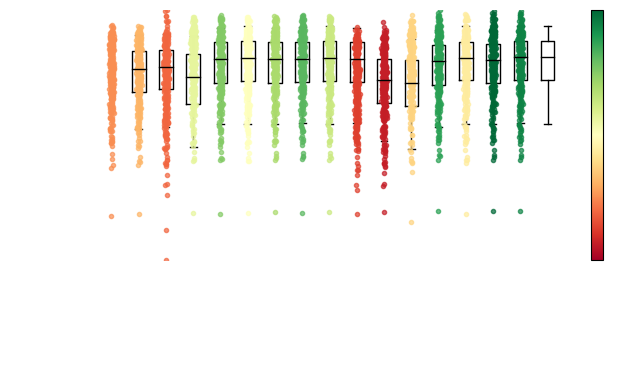

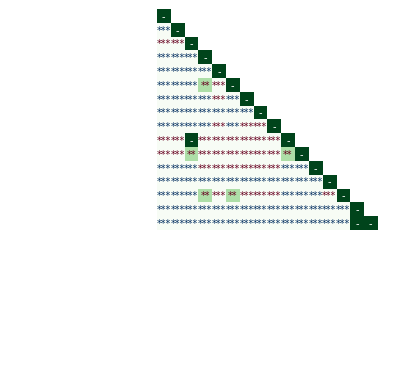

In [75]:
# Plot the training and testing scores
plt.figure(figsize=(7, 4))
plt.boxplot(training_scores, whis=[5, 95], showfliers=False, medianprops={'color': 'black'})
jitter = np.random.normal(0, 0.04, size=len(training_scores[0]))
for i in range(len(training_scores)):
    y = training_scores[i]
    x = i + jitter
    plt.plot(x, y, '.', alpha=0.7, color=plt.cm.RdYlGn(1 -(np.where(training_order==i)[0][0]/len(training_order))))
plt.axhline(0, color='black', linestyle='--')
plt.xticks(np.arange(1, len(names) + 1), [good_names[name] for name in names], rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Norm. Log Likelihood (Training)")
plt.box(False)
plt.ylim(min(min_scores_training) - offset, max(max_scores_training) + offset)
# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Rank (Higher is Better)')
cbar.ax.set_yticks([])
plt.tight_layout()
plt.show()

fig,ax = comparision_matrix(training_scores, names, 'wilcoxon')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/1616028839.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


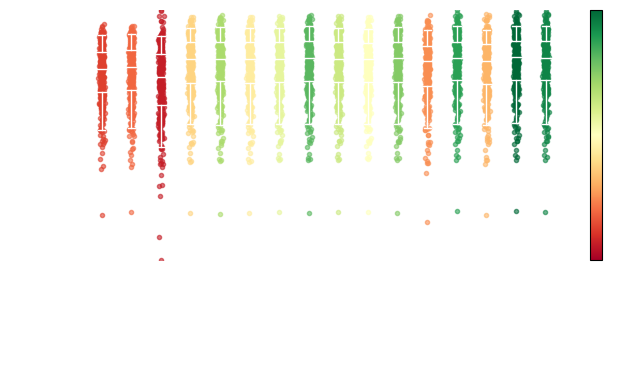

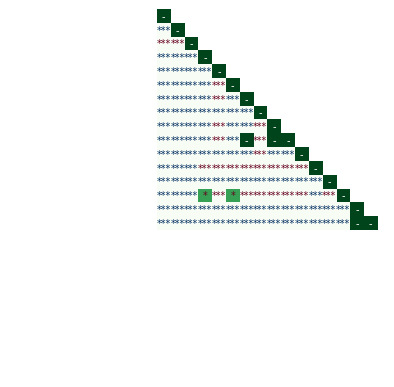

In [103]:
# Plot the training and testing scores
plt.figure(figsize=(7, 4))
plt.boxplot(testing_scores, whis=[5, 95], showfliers=False, medianprops={'color': 'white'}, boxprops={'color': 'white'}, whiskerprops={'color': 'white'}, capprops={'color': 'white'}, zorder=10)
jitter = np.random.normal(0, 0.04, size=len(testing_scores[0]))
for i in range(len(testing_scores)):
    y = testing_scores[i]
    x = i + jitter
    plt.plot(x+1, y, '.', alpha=0.6, color=plt.cm.RdYlGn(1 -(np.where(testing_order==i)[0][0]/len(testing_order))))
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(np.arange(1, len(names) + 1), [good_names[name] for name in names], rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Norm. Log Likelihood (Testing)")
plt.box(False)
plt.ylim(min(min_scores_testing) - offset, max(max_scores_testing) + offset)
# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Rank (Higher is Better)')
cbar.ax.set_yticks([])
plt.tight_layout()
plt.savefig('figures/testing_scores.svg', bbox_inches='tight')
plt.show()

fig,ax = comparision_matrix(testing_scores, names, 'wilcoxon')
plt.savefig('figures/testing_scores_matrix.svg', bbox_inches='tight')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/26828426.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_44240/26828426.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


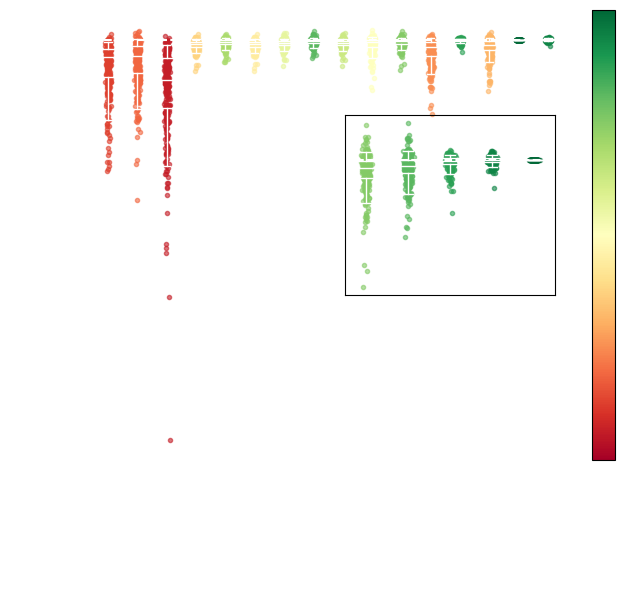

In [114]:
# Plot the training and testing scores (subtract the best)
best_model_testing = np.argmax(mean_testing_scores)

adjusted_testing_scores = [x - testing_scores[best_model_testing] for x in testing_scores]
plt.figure(figsize=(7, 6))
plt.boxplot(adjusted_testing_scores, whis=[5, 95], showfliers=False, medianprops={'color': 'white'}, boxprops={'color': 'white'}, whiskerprops={'color': 'white'}, capprops={'color': 'white'}, zorder=10)
jitter = np.random.normal(0, 0.04, size=len(adjusted_testing_scores[0]))
for i in range(len(adjusted_testing_scores)):
    y = adjusted_testing_scores[i]
    x = i + jitter + 1
    plt.plot(x, y, '.', alpha=0.6, color=plt.cm.RdYlGn(1 -(np.where(testing_order==i)[0][0]/len(testing_order))))
# add a line at 0
plt.axhline(0, color='white', linestyle='--')
plt.xticks(np.arange(1, len(names) + 1), [good_names[name] for name in names], rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Deviation in Predictive Performance\nfrom Best Model")
plt.box(False)
# plt.ylim(min(min_scores_testing) - offset, max(max_scores_testing) + offset)
# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Rank (Higher is Better)')
cbar.ax.set_yticks([])
# add a inset with the best models
ax_inset = plt.axes([0.5, 0.5, 0.3, 0.3])
subset = np.argsort(mean_testing_scores)[-5:]
subset_names = [good_names[names[n]] for n in subset]
subset_adjusted = [adjusted_testing_scores[n] for n in subset]
ax_inset.boxplot(subset_adjusted, whis=[5, 95], showfliers=False, medianprops={'color': 'white'}, boxprops={'color': 'white'}, whiskerprops={'color': 'white'}, capprops={'color': 'white'}, zorder=10)
jitter = np.random.normal(0, 0.04, size=len(subset_adjusted[0]))
for i in range(5):
    y = subset_adjusted[i]
    x = i + jitter + 1
    ax_inset.plot(x, y, '.', alpha=0.6, color=plt.cm.RdYlGn(1 -(np.where(testing_order==subset[i])[0][0]/len(testing_order))))
# add a line at 0
ax_inset.axhline(0, color='white', linestyle='--')
# add the names
ax_inset.set_xticks(np.arange(1, 6))
ax_inset.set_xticklabels(subset_names, rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

In [143]:
all_models_backup = all_models.copy()

In [144]:
all_models = all_models_backup.copy()

LOADED MODEL:  pPerfect
LOADED MODEL:  pWLSG
LOADED MODEL:  pEpsGreedy
LOADED MODEL:  LogRegCR(30)
LOADED MODEL:  LogRegFull(30)
LOADED MODEL:  QLearning
LOADED MODEL:  OSQLearning
LOADED MODEL:  FQLearning
LOADED MODEL:  OSFQLearning


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_67764/2893853383.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


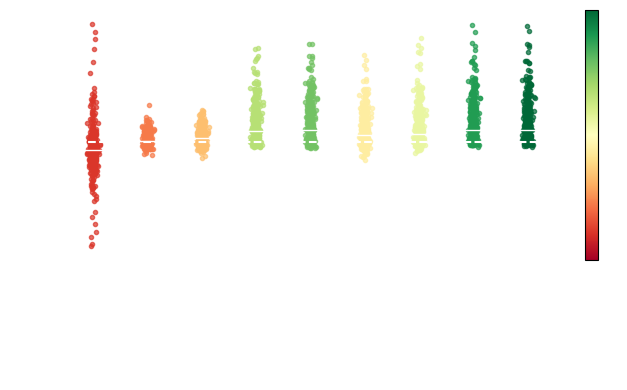

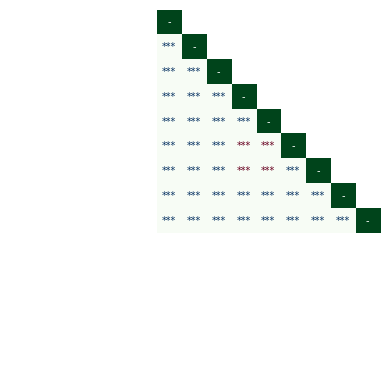

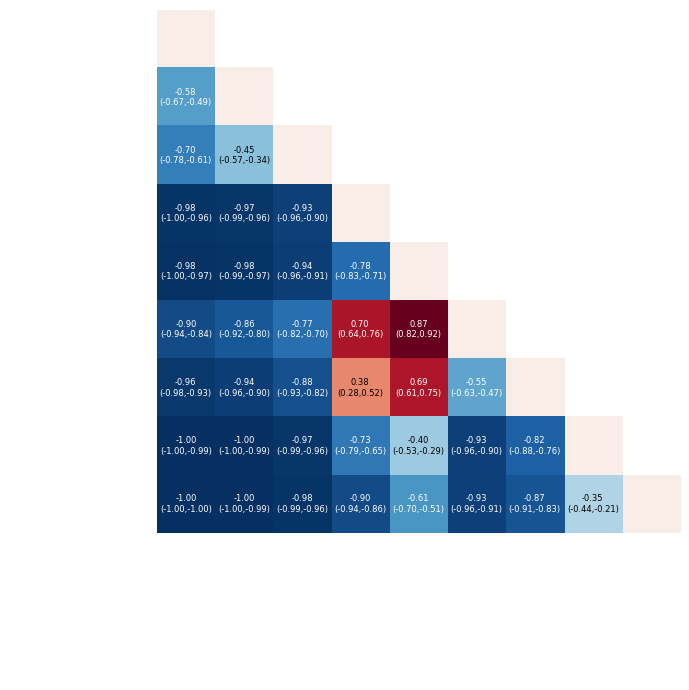

In [146]:
# remove the models that are not needed
all_models = {}
keep = [
    'pPerfect',
    'pWLSG',
    'pEpsGreedy',
    'LogRegCR(30)',
    'LogRegFull(30)',
    'QLearning',
    'OSQLearning',
    'FQLearning',
    'OSFQLearning',
]

for name in keep:
    all_models[name] = all_models_backup[name]

names = []
testing_scores = []
for name in all_models.keys():
    
    # Load all data using gzip
    with gzip.open(all_models[name], 'rb') as f:
        data = pickle.load(f)
    # Get the training and testing scores
    testing_scores.append(data['test_norm_log_liks'])
    names.append(name)
    print("LOADED MODEL: ", name)

max_scores_testing = [np.max(x) for x in testing_scores]
min_scores_testing = [np.min(x) for x in testing_scores]
offset = 0.05

mean_testing_scores = [np.mean(x) for x in testing_scores]

testing_order = np.argsort(mean_testing_scores)[::-1]

# Plot the training and testing scores

plt.figure(figsize=(7, 4))
plt.boxplot(testing_scores, whis=[5, 95], showfliers=False, medianprops={'color': 'white'}, boxprops=dict(color='white'), whiskerprops=dict(color='white'), capprops=dict(color='white'))
jitter = np.random.normal(0, 0.04, size=len(testing_scores[0]))
for i in range(len(testing_scores)):
    y = testing_scores[i]
    x = i+1 + jitter
    plt.plot(x, y, '.', alpha=0.7, color=plt.cm.RdYlGn(1 -(np.where(testing_order==i)[0][0]/len(testing_order))))
plt.axhline(0.5, color='white', linestyle='--')
plt.xticks(np.arange(1, len(names) + 1), [good_names[name] for name in names], rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Norm. Log Likelihood")
plt.box(False)
plt.ylim(min(min_scores_testing) - offset, max(max_scores_testing) + offset)
# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Rank (Higher is Better)')
cbar.ax.set_yticks([])
plt.tight_layout()
plt.savefig('figures/testing_scores_minimal.svg', bbox_inches='tight')

plt.show()

fig,ax = comparision_matrix(testing_scores, names, 'wilcoxon')
plt.savefig('figures/testing_scores_matrix_minimal.svg', bbox_inches='tight')
plt.show()

fig,ax = comparision_matrix(testing_scores, names, 'pairedRankBiserialCorrelation')
plt.savefig('figures/testing_scores_matrix_minimal.svg', bbox_inches='tight')
plt.show()

In [123]:
all_models = all_models_backup.copy()

In [124]:
# names = []
# train_probs = []
# test_probs = []
# for name in all_models.keys():
#     print("LOADING MODEL: ", name)
#     # Load all data using gzip
#     with gzip.open(all_models[name], 'rb') as f:
#         data = pickle.load(f)
#     # Get the training and testing probabilities
#     temp = data['train_probs']
#     train_probs.append(list(temp[0])+list(temp[1]))
    
#     temp = data['test_probs']
#     test_probs.append(list(temp[0])+list(temp[1]))
#     names.append(name)

In [125]:
# train_or_test = 'test'

# if train_or_test == 'train':
#     choices = []
#     rewards = []
#     for c,r in split_data:
#         choices=choices+c
#         rewards=rewards+r
#     choice_probs = train_probs.copy()
# else:
#     choices = []
#     rewards = []
#     for c,r in split_data[::-1]:
#         choices=choices+c
#         rewards=rewards+r
#     choice_probs = test_probs.copy()

In [126]:
# import plotly.graph_objects as go
# import plotly.express as px


# window = 15

# # Create figure
# fig = go.Figure()

# # add scatter for choices and rewards
# # choices = []
# # for i in range(len(choice_data)):
# #     choices.append(get_valid_data(choice_data[i]))
# # rewards = []
# # for i in range(len(reward_data)):
# #     rewards.append(get_valid_data(reward_data[i]))
# # assert len(choices) == len(rewards), "Number of choices and rewards do not match"

# N_flies = len(choices)
# N_models = len(choice_probs)

# for i in range(N_flies):
#     N_trials = len(choices[i])
#     # x is the trial number
#     x = np.arange(N_trials)
#     # y is the choice
#     c = choices[i]
#     r = rewards[i]
#     # color is function of reward and choice (use RdBu colormap)
#     col=(((r+1)*(1-2*c))+2)/4
#     fig.add_trace(
#         go.Scatter(
#             visible=False,
#             mode='markers',
#             marker=dict(
#                 size=10,
#                 color=col,
#                 colorscale='RdBu',
#                 showscale=False,
#                 opacity=0.5
#             ),
#             name=f"Fly {i+1}",
#             x=x,
#             y=c
#         )
#     )

#     # show the probability of choosing odor 1 for all models
#     for j in range(N_models):
#         # get the probability of choosing odor 1
#         p = choice_probs[j][i]
#         # convert to a smoothed probability
#         p = np.convolve(np.concatenate([0.5*np.ones(window-1),p]), np.ones(window)/window, mode='valid')[:N_trials]
#         model_color = plt.cm.viridis_r(j/N_models)
#         clr_str = f'rgb({int(model_color[0]*255)},{int(model_color[1]*255)},{int(model_color[2]*255)})'
#         # add a trace for the probability
#         fig.add_trace(
#             go.Scatter(
#                 visible=False,
#                 mode='lines',
#                 line=dict(
#                     color=clr_str,
#                     width=2
#                 ),
#                 name=f"{names[j]} (Smoothed)",
#                 x=x,
#                 y=p
#             )
#         )
        
#     # add a trace for the smoothed choice probability at the front of all traces
#     c_smooth = np.convolve(np.concatenate([0.5*np.ones(window-1),c]), np.ones(window)/window, mode='valid')[:N_trials]
#     fig.add_trace(
#         go.Scatter(
#             visible=False,
#             mode='lines',
#             line=dict(
#                 color='black',
#                 width=5
#             ),
#             name=f"Choice Probability (Smoothed)",
#             x=x,
#             y=c_smooth,
#         )
#     )

# def show_fly(x):
#     visible = [False]*len(fig.data)
#     block_size = 2 + N_models
#     visible[x*block_size:(x+1)*block_size] = [True]*block_size
#     return visible

# # show the first fly and show all models (keep only one enabled for now)
# fig.data[0].visible = True
# fig.data[1].visible = True
# for i in range(N_models):
#     fig.data[2+i].visible = True

# # Create and add slider for fly number
# steps = []
# for i in range(N_flies):
#     step = dict(
#         method="update",
#         args=[{"visible": show_fly(i)},
#               {"title": f"Fly {i+1} Choice Predictions"}],  # layout attribute
#         label=f"Fly {i+1}"
#     )
#     steps.append(step)

# sliders = [dict(
#     active=0,
#     currentvalue={"prefix": "Fly: "},
#     pad={"t": 50},
#     steps=steps
# )]

# # Set plot properties
# fig.update_layout(
#     plot_bgcolor='white',
#     title_x=0.5,
#     xaxis_title="Trial Number",
#     yaxis_title="Choice",
#     yaxis=dict(
#         tickmode='array',
#         tickvals=[0,1],
#         ticktext=['Odor 1', 'Odor 2']
#     ),
#     sliders=sliders
# )

# # save figure as independent html
# fig.write_html("choices_rewards.html")

Clear our all unnecessary models from all_models

In [127]:
all_models_backup = all_models.copy()

In [226]:
all_models = all_models_backup.copy()

In [227]:
# remove the models that are not needed
all_models = {}
keep = ['LogRegFull(30)', 'OSFQLearning']
for name in keep:
    all_models[name] = all_models_backup[name]

print(all_models)

{'LogRegFull(30)': '../processed_data/dmData_14-09-2023/fit_results/logreg_30_full_fit_results.pkl.gz', 'OSFQLearning': '../processed_data/dmData_14-09-2023/fit_results/OSFQLearning_fit_results.pkl.gz'}


## Add neuronal models

In [228]:
neuronal_models={
    # "UD_H":fit_path+f'fit_results/homeostatic_plasticity/univalent_depression_fit_results.pkl.gz',
    "UM":fit_path+f'fit_results/modulatory/Feb2024/univalent_modulatory_fit_results.pkl.gz',
    "BM":fit_path+f'fit_results/modulatory/Feb2024/bivalent_modulatory_fit_results.pkl.gz',
    "UB":fit_path+f'fit_results/modulatory/Feb2024/univalent_bidirectional_modulatory_fit_results.pkl.gz',
    # "UB_H":fit_path+f'fit_results/homeostatic_plasticity/univalent_bidirectional_fit_results.pkl.gz',
    # "BP_H":fit_path+f'fit_results/homeostatic_plasticity/bivalent_depression_fit_results.pkl.gz',
    # "UB_M":fit_path+f'fit_results/univalent_bidirectional_modulatory_fit_results_latest.pkl.gz',
    # "U_M":fit_path+f'fit_results/univalent_modulatory_fit_results_latest.pkl.gz',
}
    

In [229]:
for t in neuronal_models.keys(): 
    with gzip.open(neuronal_models[t], 'rb') as f:
        all_data = pickle.load(f)
        print("Loaded results from disk")
        # Unpack the results
        params = all_data['params']
        train_log_liks = all_data['train_log_liks']
        test_log_liks = all_data['test_log_liks']
        train_norm_log_liks = all_data['train_norm_log_liks']
        test_norm_log_liks = all_data['test_norm_log_liks']
        train_probs = all_data['train_probs']
        test_probs = all_data['test_probs']

    print("\nMODEL FIT")
    print("=========")
    print()
    print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
    print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
    print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
    print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))

    # Add to models list
    all_models[t] = neuronal_models[t]

Loaded results from disk

MODEL FIT

Train log likelihood: -275.304 [-600.272, -82.004]
Test log likelihood: -275.415 [-599.559, -83.281]
Train normalized log likelihood: 0.563 [0.486, 0.755]
Test normalized log likelihood: 0.563 [0.485, 0.758]
Loaded results from disk

MODEL FIT

Train log likelihood: -271.064 [-599.133, -80.125]
Test log likelihood: -271.158 [-599.482, -81.518]
Train normalized log likelihood: 0.569 [0.492, 0.781]
Test normalized log likelihood: 0.569 [0.493, 0.784]
Loaded results from disk

MODEL FIT

Train log likelihood: -275.304 [-600.287, -82.047]
Test log likelihood: -275.411 [-599.559, -83.280]
Train normalized log likelihood: 0.563 [0.486, 0.755]
Test normalized log likelihood: 0.563 [0.485, 0.758]


In [234]:
good_names = {
    'LogRegFull(30)': 'Best Regression Model',
    'OSFQLearning': 'Best Value-Learning Model',
    'UM': 'Univalent Modulatory',
    'BM': 'Bivalent Modulatory',
    'UD_H': 'Circuit Model C',
    'UB': 'Univalent Bidirectional Modulatory',
    # 'UB_H': 'Univalent Bidirectional',
    # 'BP_H': 'Bivalent Depression',
    # 'UB_M': 'Univalent Bidirectional Modulatory',
    # 'U_M': 'Univalent Modulatory',
}

In [235]:
names = []
training_scores = []
testing_scores = []
for name in all_models.keys():
    
    # Load all data using gzip
    with gzip.open(all_models[name], 'rb') as f:
        data = pickle.load(f)
    # Get the training and testing scores
    training_scores.append(data['train_norm_log_liks'])
    testing_scores.append(data['test_norm_log_liks'])
    names.append(name)
    print("LOADED MODEL: ", name)

max_scores_training = [np.max(x) for x in training_scores]
max_scores_testing = [np.max(x) for x in testing_scores]
min_scores_training = [np.min(x) for x in training_scores]
min_scores_testing = [np.min(x) for x in testing_scores]
offset = 0.05

mean_training_scores = [np.mean(x) for x in training_scores]
mean_testing_scores = [np.mean(x) for x in testing_scores]

training_order = np.argsort(mean_training_scores)[::-1]
testing_order = np.argsort(mean_testing_scores)[::-1]

LOADED MODEL:  LogRegFull(30)
LOADED MODEL:  OSFQLearning
LOADED MODEL:  UM
LOADED MODEL:  BM
LOADED MODEL:  UB


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_67764/1065822949.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


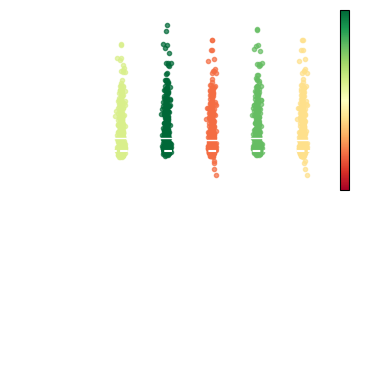

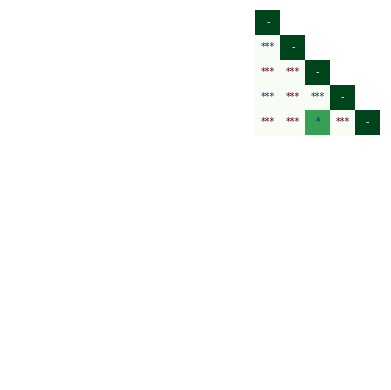

In [236]:
# Plot the training and testing scores
plt.figure(figsize=(4, 4))
plt.boxplot(testing_scores, whis=[5, 95], showfliers=False, medianprops={'color': 'white'}, boxprops=dict(color='white'), whiskerprops=dict(color='white'), capprops=dict(color='white') )
jitter = np.random.normal(0, 0.04, size=len(testing_scores[0]))
for i in range(len(testing_scores)):
    y = testing_scores[i]
    x = i+1 + jitter
    plt.plot(x, y, '.', alpha=0.7, color=plt.cm.RdYlGn(1 -(np.where(testing_order==i)[0][0]/len(testing_order))))
plt.axhline(0.5, color='white', linestyle='--')
plt.xticks(np.arange(1, len(names) + 1), [good_names[name] for name in names], rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Norm. Log Likelihood (Testing)")
plt.box(False)
plt.ylim(min(min_scores_testing) - offset, max(max_scores_testing) + offset)
# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Rank (Higher is Better)')
cbar.ax.set_yticks([])
plt.tight_layout()
plt.savefig('figures/neuronal_testing_scores.svg', bbox_inches='tight')
plt.show()

fig,ax = comparision_matrix(testing_scores, names, 'wilcoxon')
plt.savefig('figures/neuronal_testing_scores_matrix.svg', bbox_inches='tight')
plt.show()

In [233]:
from pygorl.neuronal import UnivalentModulatory, BivalentModulatory, UnivalentBidirectionalModulatory

ImportError: cannot import name 'UnivalentBidirectionalModulatory' from 'pygorl.neuronal' (/Users/neurorishika/Projects/Models/2afc/pyGORL/pygorl/neuronal.py)

In [196]:
with gzip.open(neuronal_models['UM'], 'rb') as f:
    all_data = pickle.load(f)
    params = all_data['params']
neuronal_model = UnivalentModulatory

In [197]:
# get average params for each key
avg_params = {}
for key in params[0].keys():
    avg_params[key] = np.mean([params[0][key],params[1][key]],axis=0)
    print(f"{key}: {avg_params[key]}")

fr: 0.022037384098398453
lr: 0.22708154379475998
up_dr: 2.4240371897032755
fb_trans: 0.4354284729272445
fb_up: 0.5547356448951347
mu_inh: 0.0
fb_syn: 0.0


In [198]:
generative_mode = True

In [199]:
# generate data with this model
n_data = N # number of experiments

# loop over experiments
generated_choices = []
generated_rewards = []
true_probs = []

for i in tqdm(range(n_data)):
    # choose the number of trials from data
    p_1,p_2,n_trials = get_probabilities(i%360,return_trial_count=True)
    reward_schedule = np.zeros((n_trials,2))
    for j in range(n_trials):
        reward_schedule[j,0] = np.random.choice([0,1],p=[1-p_1[j],p_1[j]])
        reward_schedule[j,1] = np.random.choice([0,1],p=[1-p_2[j],p_2[j]])
    # perform simulation
    MB = neuronal_model(**avg_params)
    upwind_drive = MB.upwind_drive()
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    # randomly choose the odor
    choice = np.random.choice([0,1],p=upwind_drive)
    choices=[choice]
    rewards = []
    for j in range(n_trials):
        rewards.append(reward_schedule[j,choices[j]])
        if generative_mode:
            MB.trial_plasticity(choices[j],reward_schedule[j,choices[j]])
        else:
            MB.trial_plasticity(choice_data[i%360][j],reward_data[i%360][j])
        upwind_drive = MB.upwind_drive()
        # apply softmax to upwind drivess
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        # randomly choose the odor
        choice = np.random.choice([0,1],p=upwind_drive)
        choices.append(choice)

    rewards = np.array(rewards)
    choices = np.array(choices[:-1])

    generated_choices.append(choices)
    generated_rewards.append(rewards)

generated_choices = np.array(generated_choices,dtype=object)
generated_rewards = np.array(generated_rewards,dtype=object)


  0%|          | 0/360 [00:00<?, ?it/s]

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_67764/4282944586.py:17: RuntimeWarning: invalid value encountered in scalar divide
  rolling_r.append(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1)/(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1) + np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==0)))


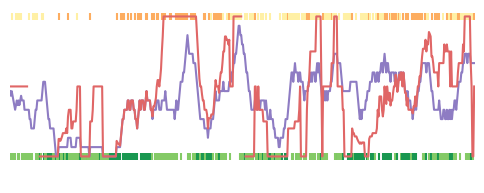

In [200]:
# check the generated data
fly_no = 45
c = generated_choices[fly_no]
r = generated_rewards[fly_no]
t = len(c)
col = ((((r+1)*(1-2*c))+2)/4)
# get rolling average
HISTORY_SIZE = 15
# append 0.5s to the beginning
c_ = np.concatenate((np.tile(0.5, HISTORY_SIZE-1), c))
r_ = np.concatenate((np.tile(0, HISTORY_SIZE-1), r))
rolling_r = []
for i in range(t):
    if np.sum(r[i:i+HISTORY_SIZE]) == 0:
        rolling_r.append(0.5)
    else:
        rolling_r.append(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1)/(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1) + np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==0)))
rolling_r = np.array(rolling_r)
rolling_c = np.convolve(c_, np.ones(HISTORY_SIZE)/HISTORY_SIZE, mode='valid')
plt.figure(figsize=(6,2))
plt.scatter(np.arange(t), c, c=col, cmap=OrGn, s=20,marker='|')
plt.plot(np.arange(t), rolling_c, color='#8E7CC3', linewidth=1.5)
plt.plot(np.arange(t), rolling_r, color='#E06666', linewidth=1.5)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.gca().set_xlim([0,t])
# plt.gca().set_ylim([0,1])
plt.box(False)
plt.gca().set_xlabel('Trial#')
plt.savefig('figures/fly_choices.svg', format='svg')
plt.show()


In [201]:
recalculate = True

In [202]:
# get baseline coefficients for the whole dataset

n_shuffles = 10

# Parameters
HISTORY_SIZE = 30
MODE = 'full'

if os.path.isfile(fit_path+f'fit_results/UD_sim_shuffled_coefficients.pkl') and not recalculate:

    # Load the data
    with open(fit_path+f'fit_results/UD_sim_shuffled_coefficients.pkl', 'rb') as f:
        shuffled_coefficients = pickle.load(f)
    with open(fit_path+f'fit_results/UD_sim_shuffled_model.pkl', 'rb') as f:
        models = pickle.load(f)

else:
    models = []
    coefs = []
    for shuffle in tqdm(range(n_shuffles)):
        # shuffle the orders
        shuffled_choices = [np.random.permutation(c) for c in generated_choices]
        shuffled_rewards = [np.random.permutation(r) for r in generated_rewards]
        # fit the model
        full_model_shuffled = fit_logreg(shuffled_choices,shuffled_rewards,history_size=HISTORY_SIZE,mode=MODE)
        # get the coefficients
        coefs.append(np.array_split(full_model_shuffled.coef_.flatten(),full_model_shuffled.coef_.shape[1]//HISTORY_SIZE))
        models.append(full_model_shuffled)

    # reshape the coefficients
    shuffled_coefficients = []
    for i in range(len(coefs[0])):
        shuffled_coefficients.append(np.array([c[i] for c in coefs]))

    # Save the data and the model
    with open(fit_path+f'fit_results/UD_sim_shuffled_coefficients.pkl', 'wb') as f:
        pickle.dump(shuffled_coefficients, f)
    with open(fit_path+f'fit_results/UD_sim_shuffled_model.pkl', 'wb') as f:
        pickle.dump(models, f)

  0%|          | 0/10 [00:00<?, ?it/s]

In [203]:
# get the mean and std for z-score
shuffled_coefficient_means = [np.mean(x,axis=0) for x in shuffled_coefficients]
shuffled_coefficient_stds = [np.std(x,axis=0) for x in shuffled_coefficients]

In [204]:
recalculate = True

ESTIMATED LOGISTIC REGRESSION (30 TRIAL HISTORY, INTERACTIONS) PARAMETERS



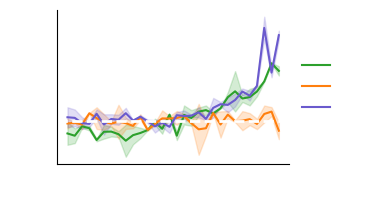


MODEL FIT

Train log likelihood: -290.459 [-550.548, -106.442]
Test log likelihood: -291.096 [-551.282, -107.031]
Train normalized log likelihood: 0.540 [0.498, 0.638]
Test normalized log likelihood: 0.540 [0.497, 0.637]



In [205]:
split_data = get_split_data(generated_choices, generated_rewards)

# Parameters
HISTORY_SIZE = 30
MODE = 'full'

# Check if the model has already been fit
if os.path.isfile(fit_path+f'fit_results/UB_sim_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz') and recalculate == False:
    # Load the results from disk
    with gzip.open(fit_path+f'fit_results/UB_sim_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    models = all_data['models']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']

# Otherwise, fit the model
else:
    # Variables to store the results
    models = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        model = fit_logreg(choices, rewards, HISTORY_SIZE, MODE)
        # Store the parameters
        models.append(model)
        # Compute the log likelihoods
        probs = predict_prob_logreg(choices, rewards, model, HISTORY_SIZE, MODE)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_logreg(choices, rewards, models[n], HISTORY_SIZE, MODE)
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'models': models,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks
    }

    # Dump to disk
    with gzip.open(fit_path+f'fit_results/UB_sim_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)

# Parameters
print("ESTIMATED LOGISTIC REGRESSION ({} TRIAL HISTORY, {}) PARAMETERS".format(HISTORY_SIZE, "INTERACTIONS" if MODE == 'full' else "MAIN EFFECTS"))
print("=========================================================================")
print()

if MODE == 'full':
    names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
    colors = ['tab:green', 'tab:orange', 'slateblue', 'orchid']
else:
    names = [r'$C$', r'$R$']
    colors = ['tab:green', 'tab:orange']

fig, ax = plt.subplots(figsize=(3, 2))
for i in range(3 if MODE == 'full' else 2):
    coefs = []
    for j in range(2):
        temp = np.array_split(models[j].coef_[0], models[j].coef_[0].shape[0]//HISTORY_SIZE)[i]
        coefs.append(temp)
    
    coef_mean = np.mean(coefs, axis=0)
    coef_2_5 = np.percentile(coefs, 2.5, axis=0)
    coef_97_5 = np.percentile(coefs, 97.5, axis=0)

    # z-score the coefficients
    if z_score:
        coef_mean = (coef_mean - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]
        coef_2_5 = (coef_2_5 - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]
        coef_97_5 = (coef_97_5 - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]

    if i == 0:
        normal_coefs = coefs.copy()

    ax.fill_between(range(HISTORY_SIZE), coef_2_5, coef_97_5, alpha=0.2, color=colors[i])
    ax.plot(range(HISTORY_SIZE), coef_mean, label=names[i], color=colors[i])

# Add a horizontal line at 0
ax.axhline(0, color='white', linestyle='--', linewidth=2)

ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Coefficient{}'.format(' (Z-Scored)' if z_score else ''))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.savefig('figures/UB_sim_{}_{}_coefficients.svg'.format(HISTORY_SIZE, MODE), format='svg', bbox_inches='tight')
plt.show()

# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
print()


In [206]:
# ablate the feedback
ablated_params = avg_params.copy()
ablated_params['fb_up'] = 0

In [216]:
# generate data with this model
n_data = N # number of experiments

# loop over experiments
generated_choices = []
generated_rewards = []
true_probs = []

for i in tqdm(range(n_data)):
    # choose the number of trials from data
    p_1,p_2,n_trials = get_probabilities(i%N,return_trial_count=True)
    reward_schedule = np.zeros((n_trials,2))
    for j in range(n_trials):
        reward_schedule[j,0] = np.random.choice([0,1],p=[1-p_1[j],p_1[j]])
        reward_schedule[j,1] = np.random.choice([0,1],p=[1-p_2[j],p_2[j]])
    # perform simulation
    MB = neuronal_model(**ablated_params)
    upwind_drive = MB.upwind_drive()
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    # randomly choose the odor
    choice = np.random.choice([0,1],p=upwind_drive)
    choices=[choice]
    rewards = []
    for j in range(n_trials):
        rewards.append(reward_schedule[j,choices[j]])
        if generative_mode:
            MB.trial_plasticity(choices[j],reward_schedule[j,choices[j]])
        else:
            MB.trial_plasticity(choice_data[i%N][j],reward_data[i%N][j])
        upwind_drive = MB.upwind_drive()
        # apply softmax to upwind drivess
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        # randomly choose the odor
        choice = np.random.choice([0,1],p=upwind_drive)
        choices.append(choice)

    rewards = np.array(rewards)
    choices = np.array(choices[:-1])

    generated_choices.append(choices)
    generated_rewards.append(rewards)

generated_choices = np.array(generated_choices,dtype=object)
generated_rewards = np.array(generated_rewards,dtype=object)


  0%|          | 0/360 [00:00<?, ?it/s]

In [217]:
# # get baseline coefficients for the whole dataset

n_shuffles = 10

# Parameters
HISTORY_SIZE = 30
MODE = 'full'

if os.path.isfile(fit_path+f'fit_results/UD_sim_abl_shuffled_coefficients.pkl') and not recalculate:

    # Load the data
    with open(fit_path+f'fit_results/UD_sim_abl_shuffled_coefficients.pkl', 'rb') as f:
        shuffled_coefficients = pickle.load(f)
    with open(fit_path+f'fit_results/UD_sim_abl_shuffled_model.pkl', 'rb') as f:
        models = pickle.load(f)

else:
    models = []
    coefs = []
    for shuffle in tqdm(range(n_shuffles)):
        # shuffle the orders
        shuffled_choices = [np.random.permutation(c) for c in generated_choices]
        shuffled_rewards = [np.random.permutation(r) for r in generated_rewards]
        # fit the model
        full_model_shuffled = fit_logreg(shuffled_choices,shuffled_rewards,history_size=HISTORY_SIZE,mode=MODE)
        # get the coefficients
        coefs.append(np.array_split(full_model_shuffled.coef_.flatten(),full_model_shuffled.coef_.shape[1]//HISTORY_SIZE))
        models.append(full_model_shuffled)

    # reshape the coefficients
    shuffled_coefficients = []
    for i in range(len(coefs[0])):
        shuffled_coefficients.append(np.array([c[i] for c in coefs]))

    # Save the data and the model
    with open(fit_path+f'fit_results/UD_sim_abl_shuffled_coefficients.pkl', 'wb') as f:
        pickle.dump(shuffled_coefficients, f)
    with open(fit_path+f'fit_results/UD_sim_abl_shuffled_model.pkl', 'wb') as f:
        pickle.dump(models, f)

  0%|          | 0/10 [00:00<?, ?it/s]

In [218]:
# get the mean and std for z-score
shuffled_coefficient_means = [np.mean(x,axis=0) for x in shuffled_coefficients]
shuffled_coefficient_stds = [np.std(x,axis=0) for x in shuffled_coefficients]

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_67764/3048349870.py:17: RuntimeWarning: invalid value encountered in scalar divide
  rolling_r.append(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1)/(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1) + np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==0)))


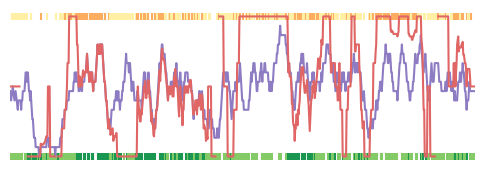

In [219]:
# check the generated data
fly_no = 50
c = generated_choices[fly_no]
r = generated_rewards[fly_no]
t = len(c)
col = ((((r+1)*(1-2*c))+2)/4)
# get rolling average
HISTORY_SIZE = 15
# append 0.5s to the beginning
c_ = np.concatenate((np.tile(0.5, HISTORY_SIZE-1), c))
r_ = np.concatenate((np.tile(0, HISTORY_SIZE-1), r))
rolling_r = []
for i in range(t):
    if np.sum(r[i:i+HISTORY_SIZE]) == 0:
        rolling_r.append(0.5)
    else:
        rolling_r.append(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1)/(np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==1) + np.sum(c_[i:i+HISTORY_SIZE][r_[i:i+HISTORY_SIZE]==1]==0)))
rolling_r = np.array(rolling_r)
rolling_c = np.convolve(c_, np.ones(HISTORY_SIZE)/HISTORY_SIZE, mode='valid')
plt.figure(figsize=(6,2))
plt.scatter(np.arange(t), c, c=col, cmap=OrGn, s=20,marker='|')
plt.plot(np.arange(t), rolling_c, color='#8E7CC3', linewidth=1.5)
plt.plot(np.arange(t), rolling_r, color='#E06666', linewidth=1.5)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.gca().set_xlim([0,t])
# plt.gca().set_ylim([0,1])
plt.box(False)
plt.gca().set_xlabel('Trial#')
plt.savefig('figures/fly_choices.svg', format='svg')
plt.show()



In [220]:
recalculate = True

ESTIMATED LOGISTIC REGRESSION (30 TRIAL HISTORY, INTERACTIONS) PARAMETERS



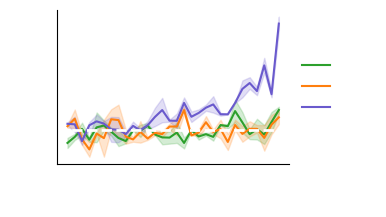


MODEL FIT

Train log likelihood: -297.751 [-574.321, -112.239]
Test log likelihood: -298.294 [-575.699, -113.118]
Train normalized log likelihood: 0.531 [0.497, 0.628]
Test normalized log likelihood: 0.531 [0.496, 0.625]



In [221]:
split_data = get_split_data(generated_choices, generated_rewards)

# Parameters
HISTORY_SIZE = 30
MODE = 'full'

# Check if the model has already been fit
if os.path.isfile(fit_path+f'fit_results/UB_ab_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz') and recalculate == False:
    # Load the results from disk
    with gzip.open(fit_path+f'fit_results/UB_ab_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'rb') as f:
        all_data = pickle.load(f)
    print("Loaded results from disk")
    # Unpack the results
    models = all_data['models']
    train_probs = all_data['train_probs']
    test_probs = all_data['test_probs']
    train_log_liks = all_data['train_log_liks']
    test_log_liks = all_data['test_log_liks']
    train_norm_log_liks = all_data['train_norm_log_liks']
    test_norm_log_liks = all_data['test_norm_log_liks']

# Otherwise, fit the model
else:
    # Variables to store the results
    models = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []

    # Fit the model to each split of the data
    for choices, rewards in split_data:
        # Fit the model
        model = fit_logreg(choices, rewards, HISTORY_SIZE, MODE)
        # Store the parameters
        models.append(model)
        # Compute the log likelihoods
        probs = predict_prob_logreg(choices, rewards, model, HISTORY_SIZE, MODE)
        train_probs.append(probs)
        train_log_liks.append(log_likelihood(probs, choices))
        train_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    # Test the model on the held-out data
    for n, (choices, rewards) in enumerate(split_data[::-1]):
        # Compute the log likelihoods
        probs = predict_prob_logreg(choices, rewards, models[n], HISTORY_SIZE, MODE)
        test_probs.append(probs)
        test_log_liks.append(log_likelihood(probs, choices))
        test_norm_log_liks.append(normalized_log_likelihood(probs, choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'models': models,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks
    }

    # Dump to disk
    with gzip.open(fit_path+f'fit_results/UB_ab_{HISTORY_SIZE}_{MODE}_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)

# Parameters
print("ESTIMATED LOGISTIC REGRESSION ({} TRIAL HISTORY, {}) PARAMETERS".format(HISTORY_SIZE, "INTERACTIONS" if MODE == 'full' else "MAIN EFFECTS"))
print("=========================================================================")
print()

if MODE == 'full':
    names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
    colors = ['tab:green', 'tab:orange', 'slateblue', 'orchid']
else:
    names = [r'$C$', r'$R$']
    colors = ['tab:green', 'tab:orange']

fig, ax = plt.subplots(figsize=(3, 2))
for i in range(3 if MODE == 'full' else 2):
    coefs = []
    for j in range(2):
        temp = np.array_split(models[j].coef_[0], models[j].coef_[0].shape[0]//HISTORY_SIZE)[i]
        coefs.append(temp)
    
    coef_mean = np.mean(coefs, axis=0)
    coef_2_5 = np.percentile(coefs, 2.5, axis=0)
    coef_97_5 = np.percentile(coefs, 97.5, axis=0)

    # z-score the coefficients
    if z_score:
        coef_mean = (coef_mean - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]
        coef_2_5 = (coef_2_5 - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]
        coef_97_5 = (coef_97_5 - shuffled_coefficient_means[i])/shuffled_coefficient_stds[i]

    if i == 0:
        ablated_coefs = coefs.copy()

    ax.fill_between(range(HISTORY_SIZE), coef_2_5, coef_97_5, alpha=0.2, color=colors[i])
    ax.plot(range(HISTORY_SIZE), coef_mean, label=names[i], color=colors[i])

# Add a horizontal line at 0
ax.axhline(0, color='white', linestyle='--', linewidth=2)

ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Coefficient{}'.format(' (Z-Scored)' if z_score else ''))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.savefig('figures/UB_ab_{}_{}_coefficients.svg'.format(HISTORY_SIZE, MODE), format='svg', bbox_inches='tight')
plt.show()

# Summarize the results (mean and 95% CI)
print("\nMODEL FIT")
print("=========")
print()
print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
    test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
print()


In [222]:
normal_coefs = np.array(normal_coefs)
ablated_coefs = np.array(ablated_coefs)

In [223]:
effect_sizes= []
for i in range(HISTORY_SIZE):
    effect_sizes.append(cohensd(normal_coefs[:,i], ablated_coefs[:,i]))
effect_sizes = np.array(effect_sizes)

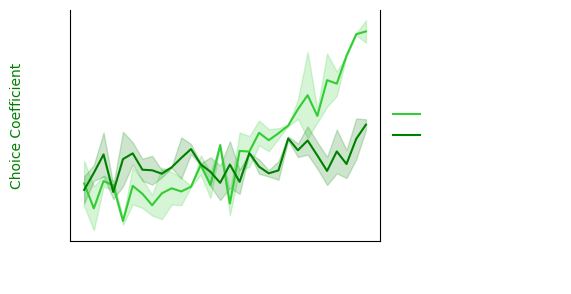

In [224]:
# plot a comparison on normal_coefs and ablated_coefs
# Plot the results
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(HISTORY_SIZE), normal_coefs.mean(axis=0), color='limegreen', label='Normal Feedback')
ax.fill_between(range(HISTORY_SIZE), np.percentile(normal_coefs, 2.5, axis=0), np.percentile(normal_coefs, 97.5, axis=0), alpha=0.2, color='limegreen')
ax.plot(range(HISTORY_SIZE), ablated_coefs.mean(axis=0), color='green', label='Feedback Ablated')
ax.fill_between(range(HISTORY_SIZE), np.percentile(ablated_coefs, 2.5, axis=0), np.percentile(ablated_coefs, 97.5, axis=0), alpha=0.2, color='green')
ax.set_xticks(range(0,HISTORY_SIZE+1,5), [str(i-HISTORY_SIZE) for i in range(0,HISTORY_SIZE+1,5)])
ax.set_xlabel('Past Trials')
ax.set_ylabel('Choice Coefficient', color='green')
ax.spines['top'].set_visible(False)

plt.savefig('figures/c_coef_ablation.svg', format='svg', bbox_inches='tight')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()



## A Neuronal Model of the Fly's Choice Behavior

We know that the mushroom body is a key structure in the fly brain that is involved in learning and memory. We also know that the mushroom body has a large number of neurons that are involved in the fly's choice behavior. 

Particularly, the Kenyon Cells (KCs) are the neurons that receive the input from the olfactory system and are involved in the fly's choice behavior. These KCs then project to the Mushroom Body Output Neurons (MBONs) which are the neurons that drive the fly's behavioral response i.e. whether the animals continue to stay in the walk upwind or turn away from the odor. However, the strength of the synaptic connections between the KCs and MBONs are not fixed, and are modulated by the dopaminergic neurons. More specifically, reward activated dopaminergic neurons depress the synaptic connections from KCs to aversive MBONs and therefore drive the fly to stay in the odor. On the other hand, punishment activated dopaminergic neurons depress the synaptic connections from KCs to appetitive MBONs and therefore drive the fly to turn away from the odor.

We can model this system to see if we can predict the fly's choice behavior. Since we have a reward only experiment, we can model the reward activated dopaminergic neurons and the aversive MBONs. We can then use the KCs as the input to the model and the MBONs as the output of the model. We can then use the MBONs activity under the two odor conditions to predict the fly's choice behavior.

Lets assume the following:
1. The KC activation by the two odors is non-overlapping i.e. each odor activates a different set of KCs, and therefore plasticity in the KC-MBON synapses is independent of each other. Thus we can consider only two populations of KCs, one for each odor.


In [43]:
# define a class for modelling the mushroom body
class MushroomBody:
    # initialize the mushroom body
    def __init__(self,mu_inh=0.1,hr=0.9,lr=0.5,up_dr=5.0,fb_syn=0.1,fb_trans=0.1,fb_up=1.0):
        self.hr = hr # homeostatic plasticity rate
        self.lr = lr # learning rate
        self.w_KC_pMBON = np.array([1.0, 1.0]) # weights from KC to MBON (appetitive)
        self.w_KC_nMBON = np.array([1.0, 1.0]) # weights from KC to MBON (aversive)
        # mutual inhibition between MBONs (Felsenberg et al., 2018)
        self.w_nMBON_pMBON = -1.0*mu_inh # weight from aversive MBON to appetitive MBON 
        self.w_pMBON_nMBON = -1.0*mu_inh # weight from appetitive MBON to aversive MBON
        # MBON to DAN feedback
        self.w_pMBON_pDANs = -1.0*fb_syn # weight from appetitive MBON to reward DANs (inhibitory to subtract reward expectation)
        self.w_nMBON_nDANs = -1.0*fb_syn # weight from aversive MBON to punishment DANs (inhibitory to subtract punishment expectation)
        self.w_pMBON_nDANs = 1.0*fb_trans # weight from appetitive MBON to punishment DANs (excitatory to add reward expectation)
        self.w_nMBON_pDANs = 1.0*fb_trans # weight from aversive MBON to reward DANs (excitatory to add punishment expectation)
        # Upwind Neuron inputs
        self.w_pMBON_U = 1.0*up_dr # weight from appetitive MBON to upwind neuron (appetitive means upwind will be activated)
        self.w_nMBON_U = -1.0*up_dr # weight from aversive MBON to upwind neuron (aversive means upwind will be inhibited)
        # Upwind Neuron feedback to Dopamine Neurons
        self.w_U_pDANs = 1.0*fb_up # weight from upwind neuron to reward DANs
        self.w_U_nDANs = -1.0*fb_up # weight from upwind neuron to punishment DANs
        # Activation function 
        self.activation = lambda x: x if x>0 else 0 # ReLU activation function

        # to store current values
        self.MBON_actvity = np.array([0.0, 0.0])
        self.DAN_activity = np.array([0.0, 0.0])
        self.U_activity = 0.0

    # get the upwind drive for each odor without causing plasticity
    def upwind_drive(self, time_since_last_trial,verbose=False):
        """
        A function to calculate the upwind drive for each odor without causing plasticity
        
        Parameters:
        -----------
        time_since_last_trial: float
            time since last trial in seconds
        verbose: bool
            whether to print the values at each step
        """
        if verbose:
            print("\nCalculating upwind drive for Odor 1 and Odor 2 after {:.0f} seconds".format(time_since_last_trial))

        drives = []
        for KC_activation in [np.array([1,0]),np.array([0,1])]:
            
            if verbose:
                print("KC activations:", KC_activation)
            
            # Step 1: calculate the KC MBON weights after homeostatic plasticity (exponential decay back to 1)
            w_KC_pMBON_ = self.w_KC_pMBON + (1-self.w_KC_pMBON)*(1-np.exp(-self.hr*time_since_last_trial))
            w_KC_nMBON_ = self.w_KC_nMBON + (1-self.w_KC_nMBON)*(1-np.exp(-self.hr*time_since_last_trial))
            
            if verbose:
                print("KC->MBON weights before homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)
                print("KC->MBON weights after plasticity: Appetitive", w_KC_pMBON_, "Aversive", w_KC_nMBON_)
            
            
            # Step 2: calculate the MBON activations
            MBON_activation = np.array(
                [
                    self.activation(np.dot(w_KC_pMBON_, KC_activation)),
                    self.activation(np.dot(w_KC_nMBON_, KC_activation))
                ]
            )
            
            if verbose:
                print("MBON activations: Appetitive", MBON_activation[0], "Aversive", MBON_activation[1])
            
            
            # Step 3: account for mutual inhibition between MBONs
            MBON_updated = np.array(
                [
                    self.activation(MBON_activation[0] + self.w_nMBON_pMBON*MBON_activation[1]),
                    self.activation(MBON_activation[1] + self.w_pMBON_nMBON*MBON_activation[0])
                ]
            )
            
            if verbose:
                print("MBON activations after mutual inhibition: Appetitive", MBON_updated[0], "Aversive", MBON_updated[1])
            
            
            # Step 4: calculate the upwind drive
            upwind_drive = self.activation(np.dot(MBON_updated, np.array([self.w_pMBON_U, self.w_nMBON_U])))
            
            if verbose:
                print("Upwind drive:", upwind_drive)
            
            drives.append(upwind_drive)
    
        if verbose:
            print()
            
        return drives



    def trial_plasticity(self, odor, reward, time_since_last_trial,verbose=False):
        """
        A function to calculate the plasticity for a single trial

        Parameters:
        -----------
        odor: int
            odor number (0 or 1)
        reward: int
            reward number (-1 or 1 or 0)
        time_since_last_trial: float
            time since last trial in seconds (for now we set it to 1 arbitrary trial length)
        verbose: bool
            whether to print the values at each step
        """

        if verbose:
            print("\nCalculating plasticity for Odor {} and {} after {:.0f} seconds".format(odor+1, "Reward" if reward==1 else "Punishment", time_since_last_trial))

        # Step 0: calculate the KC activations
        if odor == 0:
            KC_activation = np.array([1,0])
        elif odor == 1:
            KC_activation = np.array([0,1])
        
        if verbose:
            print("KC activations:", KC_activation)

        # Step 0.5: calculate the DAN activations
        if reward == 1:
            pDAN_activation = 1
            nDAN_activation = 0
        elif reward == -1:
            pDAN_activation = 0
            nDAN_activation = 1
        else:
            pDAN_activation = 0
            nDAN_activation = 0
        
        if verbose:
            print("DAN activations: Reward", pDAN_activation, "Punishment", nDAN_activation)

        # Step 1: calculate the KC MBON weights after homeostatic plasticity (exponential decay back to 1)
        if verbose:
            print("KC->MBON weights before homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)

        self.w_KC_pMBON = self.w_KC_pMBON + (1-self.w_KC_pMBON)*(1-np.exp(-self.hr*time_since_last_trial))
        self.w_KC_nMBON = self.w_KC_nMBON + (1-self.w_KC_nMBON)*(1-np.exp(-self.hr*time_since_last_trial))

        if verbose:
            print("KC->MBON weights after homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)


        # Step 2: calculate the MBON activations
        MBON_activation = np.array(
            [
                self.activation(np.dot(self.w_KC_pMBON, KC_activation)),
                self.activation(np.dot(self.w_KC_nMBON, KC_activation))
            ]
        )

        if verbose:
            print("MBON activations: Appetitive", MBON_activation[0], "Aversive", MBON_activation[1])

        # Step 3: account for mutual inhibition between MBONs
        MBON_updated = np.array(
            [
                self.activation(MBON_activation[0] + self.w_nMBON_pMBON*MBON_activation[1]),
                self.activation(MBON_activation[1] + self.w_pMBON_nMBON*MBON_activation[0])
            ]
        )

        if verbose:
            print("MBON activations after mutual inhibition: Appetitive", MBON_updated[0], "Aversive", MBON_updated[1])

        self.MBON_actvity = MBON_updated

        # Step 4: calculate the upwind drive
        upwind_drive = self.activation(np.dot(MBON_updated, np.array([self.w_pMBON_U, self.w_nMBON_U])))

        if verbose:
            print("Upwind drive:", upwind_drive)

        self.U_activity = upwind_drive

        # Step 5: calculate the DAN activations
        pDAN_activation = self.activation(pDAN_activation + self.w_U_pDANs*upwind_drive + self.w_pMBON_pDANs*MBON_updated[0] + self.w_nMBON_pDANs*MBON_updated[1])
        nDAN_activation = self.activation(nDAN_activation + self.w_U_nDANs*upwind_drive + self.w_pMBON_nDANs*MBON_updated[0] + self.w_nMBON_nDANs*MBON_updated[1])

        if verbose:
            print("DAN activations: Reward", pDAN_activation, "Punishment", nDAN_activation)

        self.DAN_activity = np.array([pDAN_activation, nDAN_activation])

        # Step 6: calculate the plasticity
        if verbose:
            print("KC->MBON weights before plasticity: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)

        self.w_KC_pMBON = self.w_KC_pMBON - self.lr*nDAN_activation*KC_activation*self.w_KC_pMBON
        self.w_KC_nMBON = self.w_KC_nMBON - self.lr*pDAN_activation*KC_activation*self.w_KC_nMBON

        if verbose:
            print("KC->MBON weights after plasticity: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)
            print()

    def get_weights(self):
        return self.w_KC_pMBON, self.w_KC_nMBON      

    def get_MBON_activity(self):
        return self.MBON_actvity

    def get_DAN_activity(self):
        return self.DAN_activity

    def get_U_activity(self):
        return self.U_activity  

In [44]:
# for now, we will ignore 
# 1) cross modal plasticity so mu_inh = 0
# 2) cross modal excitation so fb_trans = 0
ignored_params = {
    'mu_inh': 0.0,
    'fb_trans': 0.0
}

In [45]:
MB = MushroomBody(**ignored_params)
print("Initial KC to MBON weights: p ", MB.get_weights()[0], " and n ", MB.get_weights()[1])
# get the upwind drive for each odor without causing plasticity
drives = MB.upwind_drive(0)
print("Upwind drive for odor 1: ", drives[0], " and odor 2: ", drives[1])
# run a trial with odor 1 and reward
MB.trial_plasticity(0,1,0,verbose=True)
print("Updated KC to MBON weights: p ", MB.get_weights()[0], " and n ", MB.get_weights()[1])
# get the upwind drive for each odor without causing plasticity
drives = MB.upwind_drive(0)
print("Upwind drive for odor 1: ", drives[0], " and odor 2: ", drives[1])

Initial KC to MBON weights: p  [1. 1.]  and n  [1. 1.]
Upwind drive for odor 1:  0  and odor 2:  0

Calculating plasticity for Odor 1 and Reward after 0 seconds
KC activations: [1 0]
DAN activations: Reward 1 Punishment 0
KC->MBON weights before homeostasis: Appetitive [1. 1.] Aversive [1. 1.]
KC->MBON weights after homeostasis: Appetitive [1. 1.] Aversive [1. 1.]
MBON activations: Appetitive 1.0 Aversive 1.0
MBON activations after mutual inhibition: Appetitive 1.0 Aversive 1.0
Upwind drive: 0
DAN activations: Reward 0.9 Punishment 0
KC->MBON weights before plasticity: Appetitive [1. 1.] Aversive [1. 1.]
KC->MBON weights after plasticity: Appetitive [1. 1.] Aversive [0.55 1.  ]

Updated KC to MBON weights: p  [1. 1.]  and n  [0.55 1.  ]
Upwind drive for odor 1:  2.25  and odor 2:  0


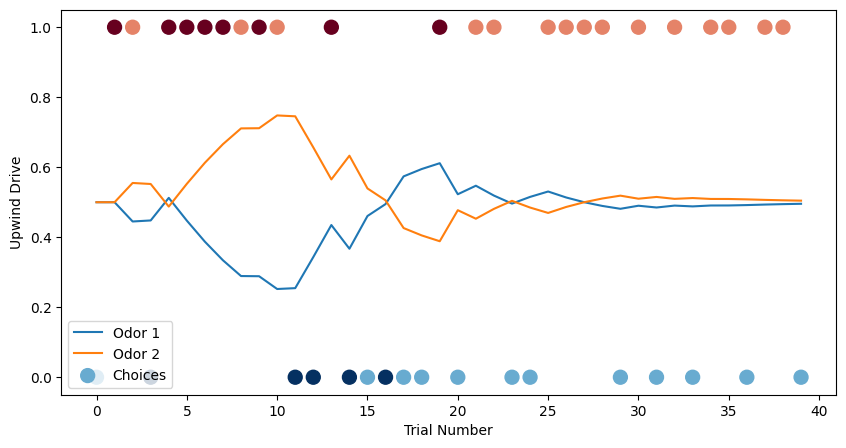

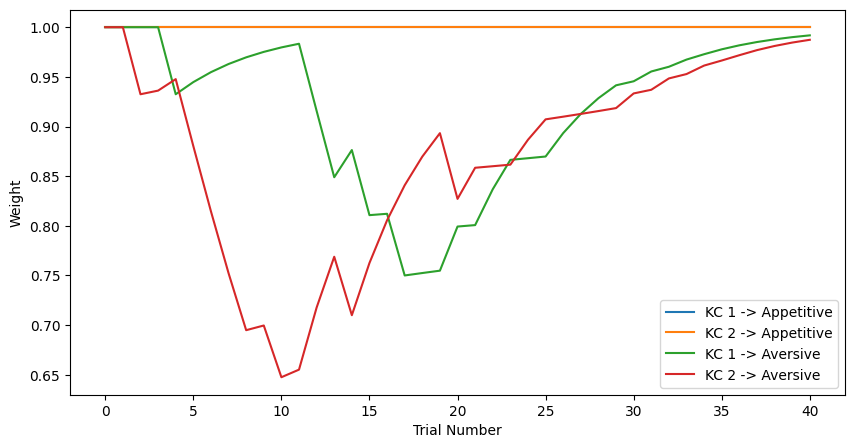

In [49]:
np.random.seed(0)
random_choices = np.concatenate([np.random.randint(0,2,size=20),np.random.randint(0,2,size=20)])
random_rewards = np.concatenate([np.random.randint(0,2,size=20),np.zeros(20)])

col=(((random_rewards+1)*(1-2*random_choices))+2)/4

MB = MushroomBody(
    hr=0.2,
    lr=0.075,
    up_dr=4,
    fb_syn=0.1,
    fb_up=1,
    **ignored_params
)
upwind_drives = []
weights = [MB.get_weights()]
for i in range(len(random_choices)):
    upwind_drive = MB.upwind_drive(1)
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    upwind_drives.append(upwind_drive)
    MB.trial_plasticity(random_choices[i],random_rewards[i],1)
    weights.append(MB.get_weights())

upwind_drives = np.array(upwind_drives)
weights = np.array(weights)

# plot the upwind drives
plt.figure(figsize=(10,5))
plt.plot(upwind_drives[:,0],label='Odor 1')
plt.plot(upwind_drives[:,1],label='Odor 2')
plt.scatter(np.arange(len(random_choices)),random_choices,c=col,s=100,label='Choices',cmap='RdBu')
plt.xlabel('Trial Number')
plt.ylabel('Upwind Drive')
plt.legend()
plt.show()

# plot the weights
plt.figure(figsize=(10,5))
plt.plot(weights[:,0,0],label='KC 1 -> Appetitive')
plt.plot(weights[:,0,1],label='KC 2 -> Appetitive')
plt.plot(weights[:,1,0],label='KC 1 -> Aversive')
plt.plot(weights[:,1,1],label='KC 2 -> Aversive')
plt.xlabel('Trial Number')
plt.ylabel('Weight')
plt.legend()
plt.show()


In [89]:
# generate data with this model
n_data = N # number of experiments

# loop over experiments
generated_choices = []
generated_rewards = []
true_probs = []

for i in tqdm(range(n_data)):
    # choose the number of trials from data
    p_1,p_2,n_trials = get_probabilities(i,return_trial_count=True)
    reward_schedule = np.zeros((n_trials,2))
    for i in range(n_trials):
        reward_schedule[i,0] = np.random.choice([0,1],p=[1-p_1[i],p_1[i]])
        reward_schedule[i,1] = np.random.choice([0,1],p=[1-p_2[i],p_2[i]])
    # perform simulation
    MB = MushroomBody(
        hr=0.2,
        lr=0.075,
        up_dr=4,
        fb_syn=0.1,
        fb_up=1.5,
        **ignored_params
        )
    upwind_drive = MB.upwind_drive(1)
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    # randomly choose the odor
    choice = np.random.choice([0,1],p=upwind_drive)
    choices=[choice]
    rewards = []
    for j in range(n_trials):
        rewards.append(reward_schedule[j,choices[j]])
        MB.trial_plasticity(choices[j],reward_schedule[j,choices[j]],1)
        upwind_drive = MB.upwind_drive(1)
        # apply softmax to upwind drivess
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        # randomly choose the odor
        choice = np.random.choice([0,1],p=upwind_drive)
        choices.append(choice)

    rewards = np.array(rewards)
    choices = np.array(choices[:-1])

    generated_choices.append(choices)
    generated_rewards.append(rewards)

generated_choices = np.array(generated_choices,dtype=object)
generated_rewards = np.array(generated_rewards,dtype=object)


  0%|          | 0/360 [00:00<?, ?it/s]

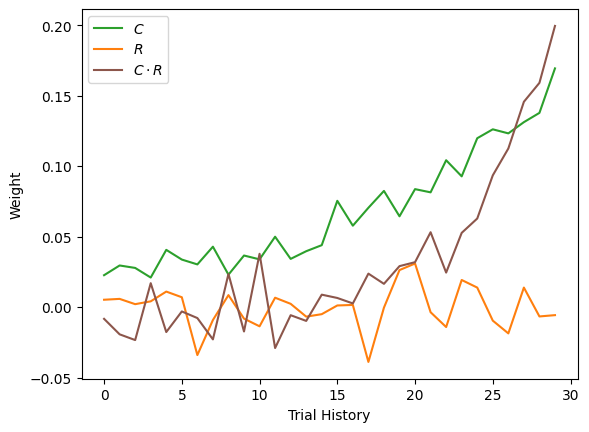

In [90]:
# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [100]:
def fit_cognitive_model(choices, rewards):
    def loglik(params):
        # params are:
        # 0: q_init_0 (initial value of odor 1)
        # 1: q_init_1 (initial value of odor 2)
        # 2: alpha_l (learning rate)
        # 3: alpha_f (forgetting rate)
        # 4: kappa (omission reward)
        # 5: delta (expectation sensitivity)
        # 5: beta (temperature)
        q_init_0,q_init_1,alpha_l, alpha_f, kappa, delta, beta = params
        sumloglik = 0
        for i in range(len(choices)):
            # initialize variables
            Q = np.array([q_init_0,q_init_1])
            Qs = [Q.copy()]
            choice_probs = []
            # get the reward schedule and choice schedule
            reward_schedule = rewards[i]
            choice_schedule = choices[i]
            # loop over trials
            for j in range(len(choice_schedule)):
                # get the choice and reward
                choice = choice_schedule[j]
                reward = reward_schedule[j]
                # calculate the probability of choosing odor 2
                p = np.clip(Q/beta,-100,100)
                p = np.exp(p)/np.sum(np.exp(p))
                choice_probs.append(p[1])
                # update the Q value
                if reward != 0:
                    Q[choice] = Q[choice] + alpha_l*(reward-delta*Q[choice])
                else:
                    Q[choice] = Q[choice] + alpha_l*(kappa-delta*Q[choice])
                Q[1-choice] = Q[1-choice] - alpha_f*(Q[1-choice])
                Qs.append(Q.copy())
            
            choice_probs = np.array(choice_probs)
            # calculate the log likelihood
            sumloglik += np.sum(np.log(choice_probs)*choice_schedule + np.log(1-choice_probs)*(1-choice_schedule))
            # plot the Q values to check
            # plt.plot(np.array(Qs)[:,0],label='Odor 1')
            # plt.plot(np.array(Qs)[:,1],label='Odor 2')
            # plt.show()
        return -sumloglik

    # set the bounds
    bounds = [(0,1),(0,1),(0,1),(0,1),(-1,1),(0,1),(0.01,100)]
    # randomly initialize the parameters within the bounds
    init_param=[]
    for b in bounds:
        init_param.append(np.random.uniform(b[0],b[1]))
    # callback function to print the current log likelihood and parameters
    def callback(xk):
        print(loglik(xk),xk)

    # run the optimization
    res = minimize(loglik, init_param, bounds=bounds, method='Nelder-Mead', callback=callback)
    print(res)

# run the model
fit_cognitive_model(generated_choices, generated_rewards)

113183.68954024713 [ 0.14164369  0.20638737  0.54166657  0.61691997 -0.46112371  0.79809731
  4.56864176]
113183.68954024713 [ 0.14164369  0.20638737  0.54166657  0.61691997 -0.46112371  0.79809731
  4.56864176]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112357.15687807082 [ 0.15097567  0.21447598  0

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_60154/2351463879.py:40: RuntimeWarning:

divide by zero encountered in log

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_60154/2351463879.py:40: RuntimeWarning:

invalid value encountered in multiply



102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0

In [108]:
params = [3.689e-01,2.511e-01,1.000e+00,9.630e-02,6.386e-01,1.027e-01,3.207e+00]

def choice_probs(params, choices,rewards):
    q_init_0,q_init_1,alpha_l, alpha_f, kappa, delta, beta = params
    probss = []
    for i in range(len(choices)):
        # initialize variables
        Q = np.array([q_init_0,q_init_1])
        Qs = [Q.copy()]
        probs = []
        # get the reward schedule and choice schedule
        reward_schedule = rewards[i]
        choice_schedule = choices[i]
        # loop over trials
        for j in range(len(choice_schedule)):
            # get the choice and reward
            choice = choice_schedule[j]
            reward = reward_schedule[j]
            # calculate the probability of choosing odor 2
            p = np.clip(Q/beta,-100,100)
            p = np.exp(p)/np.sum(np.exp(p))
            probs.append(p[1])
            # update the Q value
            if reward != 0:
                Q[choice] = Q[choice] + alpha_l*(reward-delta*Q[choice])
            else:
                Q[choice] = Q[choice] + alpha_l*(kappa-delta*Q[choice])
            Q[1-choice] = Q[1-choice] - alpha_f*(Q[1-choice])
            Qs.append(Q.copy())
        
        probs = np.array(probs)
        probss.append(probs)
    return np.array(probss,dtype=object)

# get the choice probabilities
q_probs = choice_probs(params, generated_choices, generated_rewards)
reg_probs = predict_prob_logreg(generated_choices, generated_rewards, model, HISTORY_SIZE,'full')

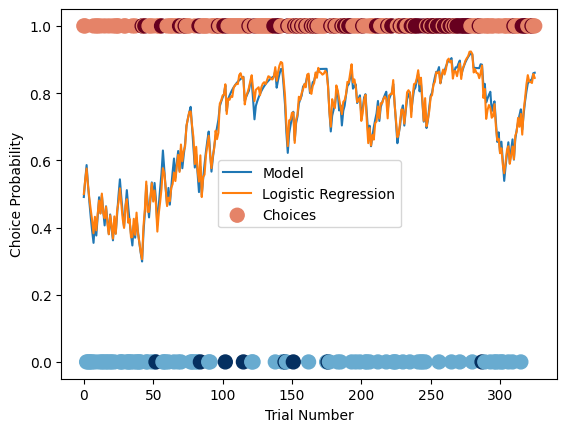

In [109]:
fly_id = 10
choices = generated_choices[fly_id]
rewards = generated_rewards[fly_id]
col = (((rewards+1)*(1-2*choices))+2)/4
plt.plot(np.arange(len(choices)),q_probs[fly_id],label='Model')
plt.plot(np.arange(len(choices)),reg_probs[fly_id],label='Logistic Regression')
plt.scatter(np.arange(len(choices)),choices,c=col,s=100,label='Choices',cmap='RdBu')
plt.xlabel('Trial Number')
plt.ylabel('Choice Probability')
plt.legend()
plt.show()

In [111]:
params

[0.3689, 0.2511, 1.0, 0.0963, 0.6386, 0.1027, 3.207]

In [279]:
# fit MB model to generated data to recover the weights (test)
def fit_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    sum_log_lik = 0
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        # calculate the log likelihood (bernoulli)
        log_lik = np.sum(np.log(upwind_drives[:,1])*choices[i] + np.log(upwind_drives[:,0])*(1-choices[i]))
        sum_log_lik += log_lik
    return sum_log_lik

# minimize the function
from scipy.optimize import minimize

# define the objective function
def objective(params):
    return -fit_MB(params,generated_choices,generated_rewards)

# define a callback function to print the progress at each iteration along with the current parameters
def callback(params):
    print('Current log likelihood: {:.3f}'.format(objective(params)))
    print("{:0.2f} {:0.2f} {:0.2f} {:0.2f} {:0.2f}".format(*params))


# define the starting point
params = np.array([0.2,0.075,4,0.1,1])+np.random.normal(0,0.2,size=5)

# constraints (all parameters must be positive and less than 1 except for the upwind drive which must be positive)
bnds = ((0.01, 1), (0.01, 1), (0.01, 10), (0.01, 1), (0.01, 1))

# perform the optimization
result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
print('Total Iterations: %d' % result['nit'])
print('Best Solution: %s' % result['x'])
print('Best Objective: %s' % result['fun'])

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_31511/1694029277.py:51: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)


Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17675.726
0.40 0.20 3.53 0.01 1.00
Current log likelihood: -17663.078
0.39 0.20 3.40 0.01 1.00
Current log likelihood: -17663.078
0.39 0.20 3.40 0.01 1.00
Current log likelihood: -17663.078
0.39 

KeyboardInterrupt: 

In [280]:
# true parameters
true_params = [0.2,0.075,4,0.1,1]
# value of the objective function at the true parameters
true_obj = -objective(true_params)
print("True Objective: ", true_obj)

True Objective:  -17431.315851000236


In [306]:
# train the model on the actual data
def fit_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    sum_log_lik = 0
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        # calculate the log likelihood (bernoulli)
        log_lik = np.sum(np.log(upwind_drives[:,1])*choices[i] + np.log(upwind_drives[:,0])*(1-choices[i]))
        sum_log_lik += log_lik
    return sum_log_lik

cs = []
for i in range(len(choice_data)):
    cs.append(get_valid_data(choice_data[i]))
rs = []
for i in range(len(reward_data)):
    rs.append(get_valid_data(reward_data[i]))
cs = np.array(cs,dtype=object)
rs = np.array(rs,dtype=object)

# define the objective function
def objective(params):
    return -fit_MB(params,cs,rs)

# define a callback function to print the progress at each iteration along with the current parameters
def callback(params):
    print('Current log likelihood: {:.3f}'.format(objective(params)))
    print("{:0.2f} {:0.2f} {:0.2f} {:0.2f} {:0.2f}".format(*params))


# define the starting point
params = np.array([0.2,0.075,4,0.1,1])+np.random.normal(0,0.2,size=5)

# constraints
bnds = ((0.01, 1), (0.01, 1), (0.01, 10), (0.01, 10), (0.01, 10))

# perform the optimization
result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
print('Total Iterations: %d' % result['nit'])
print('Best Solution: %s' % result['x'])
print('Best Objective: %s' % result['fun'])

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_31511/987101827.py:57: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)


Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95


KeyboardInterrupt: 

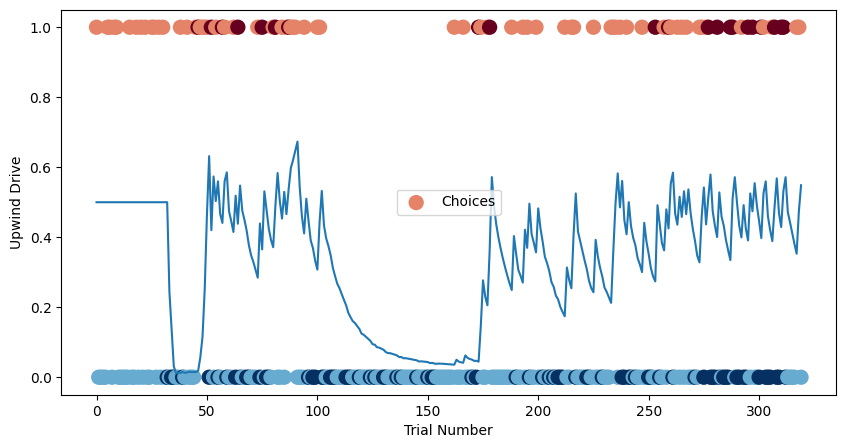

In [291]:
def pred_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    preds = []
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        preds.append(upwind_drives)
    return np.array(preds,dtype=object)
    
preds = pred_MB([0.04,0.26,3.74,0.06,0.79],cs,rs)
i = 0
col = (((rs[i]+1)*(1-2*cs[i]))+2)/4
plt.figure(figsize=(10,5))
plt.plot(preds[i][:,1])
plt.scatter(np.arange(len(cs[i])),cs[i],c=col,s=100,label='Choices',cmap='RdBu')
plt.xlabel('Trial Number')
plt.ylabel('Upwind Drive')
plt.legend()
plt.show()

### Alternative Model

#### Policy Gradient Methods

Policy gradient methods are a class of reinforcement learning methods that directly learn the policy function, i.e. the function that maps states to actions. The policy function is parameterized by a set of parameters $\theta$. The policy function is updated using the policy gradient theorem, which states that the gradient of the expected reward w.r.t. the policy parameters is equal to the expected reward times the gradient of the log of the policy function w.r.t. the policy parameters. 

The policy gradient methods are present in pygorl.cogpolicy.

For the policy gradient methods, since we are in a 1-state problem, each trial is the equivalent of a single session. So, $G_t = R_t$ for all $t$. We utilize the logistic (sigmoid) function as the policy function.

$$
\begin{gather}
\pi_t(a) = \frac{1}{1 + e^{-\theta_t}} \\
\end{gather}
$$

where $\theta_t$ is the policy parameter at trial $t$. The policy parameter is updated using the following update rule:

##### Vanilla Policy Gradient

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha \cdot R_t \cdot \Delta \pi_t(a_t) \\
\text{where } \Delta \pi_t \text{ is the gradient of the policy function w.r.t. } \theta_t \text{, evaluated at } a_t
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha$ is the learning rate for the policy parameters.

##### Actor-Critic

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \text{ and } Q_0(a) = q_{a,0} \text{ for all } a \in \mathcal{A} \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ and } Q_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha_{policy} \cdot Q_t \cdot \Delta \pi_t(a_t) \\
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_{learn} \cdot (R_t + (1-R_t)\cdot \kappa - Q_t(a_t)) \\
Q_{t+1}(a) = Q_t(a) - \alpha_{forget} \cdot Q_t(a) \text{, for all } a \neq a_t \\
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha_{policy}$ is the learning rate for the policy parameters, and $\alpha_{learn}$ and $\alpha_{forget}$ are the learning and forgetting rates for the Q-Values. $\kappa$ is the perceived reward for performing the action itself irrespective of the outcome.

### Advantage Actor-Critic

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \text{ and } V_0 = v \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ and } V_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha_{policy} \cdot \Delta \pi_t(a_t) \cdot (R_t - V_t) \\
V_{t+1} = V_t + \alpha_{value} \cdot (R_t - V_t) \\
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha_{policy}$ is the learning rate for the policy parameters, and $\alpha_{value}$ is the learning rate for the value function. $v$ is the initial value for the value function.


In [ ]:
p_models = [
    {
        'name': 'Vanilla Policy Gradient',
        'class': VLPolicyGradient,
        'addl': {},
        'dir': fit_path+'VLP_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'q'
        },
        'dir': fit_path+'ACLP_Q_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning and Forgetting Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'fq'
        },
        'dir': fit_path+'ACLP_FQ_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning, Forgetting and Omission Sensitivity Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'osfq'
        },
        'dir': fit_path+'ACLP_OSFQ_2cv_de_20230714.pkl'
    },
    {
        'name': 'Advantage Actor-Critic Policy Gradient',
        'class': AdvLPolicyGradient,
        'addl': {},
        'dir': fit_path+'AdvLP_2cv_de_20230714.pkl'
    },
]

In [ ]:
split_data = get_split_data()

for model_no in range(len(p_models)):

    models = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []
    train_pols = []
    test_pols = []

    model = p_models[model_no]['class'](**p_models[model_no]['addl'])
    params = pickle.load(open(p_models[model_no]['dir'], 'rb'))
    model_name = p_models[model_no]['name']
    print("Loaded results from disk.")

    # For train data
    for i, (choices, rewards) in enumerate(split_data):
        pols = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            pol = model.policy_gradient_learning(choices[j], rewards[j], params[i].x)
            pols.append(pol[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        train_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        train_norm_log_liks.append(normalized_log_likelihood(probs,choices))

    # For test data
    for i, (choices, rewards) in enumerate(split_data):
        pols = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            pol = model.policy_gradient_learning(choices[j], rewards[j], params[1-i].x)
            pols.append(pol[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[1-i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        test_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        test_norm_log_liks.append(normalized_log_likelihood(probs,choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_qs': train_qs,
        'test_qs': test_qs,
    }

    # Dump to disk
    ShortName = str(p_models[model_no]["class"]).split(".")[-1][:-2]
    with gzip.open(fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)



    print("ESTIMATED {} PARAMETERS".format(model_name.upper()))
    print("======================="+ "="*(len(model_name)-2))
    print()

    param_names = model.param_props()['names']
    for i, param in enumerate(param_names):
        print("{}: {:.3f}, {:.3f}".format(param, params[0].x[i], params[1].x[i]))
        
    # Summarize the results (mean and 95% CI)
    print("\nMODEL FIT")
    print("=========")
    print()
    print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
    print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
    print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
    print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
    
    # Add to models list
    # all_models[ShortName] = fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz'


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_84778/264239029.py:16: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  params = pickle.load(open(p_models[model_no]['dir'], 'rb'))


Loaded results from disk.
ESTIMATED VANILLA POLICY GRADIENT PARAMETERS

alpha: 1.000, 0.000
theta: -0.562, -0.491

MODEL FIT

Train log likelihood: -313.819 [-563.945, -142.371]
Test log likelihood: -314.409 [-563.945, -144.096]
Train normalized log likelihood: 0.497 [0.471, 0.500]
Test normalized log likelihood: 0.496 [0.467, 0.500]
Loaded results from disk.
ESTIMATED ACTOR-CRITIC POLICY GRADIENT WITH Q-LEARNING CRITIC PARAMETERS

alpha_policy: 0.000, 0.000
alpha_Q_value: 0.000, 0.000
Q_0: 0.000, 0.000
Q_1: 0.000, 0.000
theta: -3.859, 6.578

MODEL FIT

Train log likelihood: -316.087 [-580.857, -143.964]
Test log likelihood: -316.087 [-580.857, -143.964]
Train normalized log likelihood: 0.494 [0.424, 0.501]
Test normalized log likelihood: 0.494 [0.424, 0.501]
Loaded results from disk.
ESTIMATED ACTOR-CRITIC POLICY GRADIENT WITH Q-LEARNING AND FORGETTING CRITIC PARAMETERS

alpha_policy: 0.000, 0.000
alpha_Q_value: 0.000, 0.000
alpha_Q_forget: 0.000, 0.000
Q_0: 0.000, 0.000
Q_1: 0.000, 0

### Alternative Linear Regression Methods

In [ ]:
def get_design_matrix(choice, reward, history_size, mode='full'):
    """
    Returns X and y created by taking history size steps back in time to predict the current choice.

    Parameters
    ----------
    choice : array_like
        The choices made by the subject.
    reward : array_like
        The rewards received by the subject.
    history_size : int
        The number of steps back in time to take.
    mode : str, optional
        The mode to use. Can be 'full' or 'cr_only'. Default is 'full'.
    """
    if isinstance(choice, list):
        choice = np.array(choice)
    if isinstance(reward, list):
        reward = np.array(reward)
    # create copy of choice and reward
    c = choice.copy()
    r = reward.copy()
    # create dummy variables for choices of 0 and 1
    c0 = np.int32(c == 0)
    c1 = np.int32(c == 1)
    # create interactions
    # 1) Chosen 0, rewarded
    # 2) Chosen 0, not rewarded
    # 3) Chosen 1, rewarded
    # 4) Chosen 1, not rewarded
    if mode == 'full':
        c0r1 = np.int32(np.logical_and(c == 0, r == 1))
        c0r0 = np.int32(np.logical_and(c == 0, r == 0))
        c1r1 = np.int32(np.logical_and(c == 1, r == 1))
        c1r0 = np.int32(np.logical_and(c == 1, r == 0))

    if mode == 'full':
        X = np.zeros((len(c), history_size * 7))
    elif mode == 'cr_only':
        X = np.zeros((len(c), history_size * 3))
    y = np.zeros(len(c))

    # Pad choices with 0.5, rewards with 0, interactions with 0
    c = np.concatenate((0.5*np.ones(history_size), c))
    c0 = np.concatenate((np.zeros(history_size), c0))
    c1 = np.concatenate((np.zeros(history_size), c1))
    r = np.concatenate((np.zeros(history_size), r))
    if mode == 'full':
        c0r1 = np.concatenate((np.zeros(history_size), c0r1))
        c0r0 = np.concatenate((np.zeros(history_size), c0r0))
        c1r1 = np.concatenate((np.zeros(history_size), c1r1))
        c1r0 = np.concatenate((np.zeros(history_size), c1r0))

    # Fill design matrix
    for n,i in enumerate(range(history_size, len(c))):
        if mode == 'full':
            X[n, 0:history_size] = c0[i - history_size:i]
            X[n, history_size:2 * history_size] = c1[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = r[i - history_size:i]
            X[n, 3 * history_size:4 * history_size] = c0r1[i - history_size:i]
            X[n, 4 * history_size:5 * history_size] = c0r0[i - history_size:i]
            X[n, 5 * history_size:6 * history_size] = c1r1[i - history_size:i]
            X[n, 6 * history_size:7 * history_size] = c1r0[i - history_size:i]
        elif mode == 'cr_only':
            X[n, 0:history_size] = c0[i - history_size:i]
            X[n, history_size:2 * history_size] = c1[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = r[i - history_size:i]
        y[n] = c[i]
    return X, y

c [0.5 0.5 1.  0.  0.  1.  0.  1. ]
c0 [0. 0. 0. 1. 1. 0. 1. 0.]
c1 [0. 0. 1. 0. 0. 1. 0. 1.]
r [0. 0. 1. 0. 0. 1. 0. 1.]
c0r1 [0. 0. 0. 0. 0. 0. 0. 0.]
c0r0 [0. 0. 0. 1. 1. 0. 1. 0.]
c1r1 [0. 0. 1. 0. 0. 1. 0. 1.]
c1r0 [0. 0. 0. 0. 0. 0. 0. 0.]


(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]]),
 array([1., 0., 0., 1., 0., 1.]))